SMA, EMA, MACD, Kalman, Fourier, Wavelet, STL on ARIMA, LSTM, CNN, RNN on different datasets

[Source](https://wire.insiderfinance.io/cracking-the-code-stock-prediction-with-attention-based-lstm-rnn-and-cnn-a-complete-python-2c46e8f25a12)

[Source2](https://towardsdatascience.com/time-series-analysis-visualization-forecasting-with-lstm-77a905180eba)

[Source3](https://medium.com/@wl8380/mastering-day-trading-with-lstm-predicting-the-next-10-minutes-4e03f89fef3f)

[Optuna](https://optuna.readthedocs.io/en/v2.0.0/reference/generated/optuna.trial.Trial.html), [Link2](https://medium.com/@elsaannacantik/forecasting-with-xgboost-catboost-and-lgbm-51832899dacc), [Link3](https://medium.com/@elsaannacantik/forecasting-with-xgboost-catboost-and-lgbm-51832899dacc)

[Tensorflow example](https://www.tensorflow.org/tutorials/structured_data/time_series#multi-output_models)

#### Import Libraries

In [36]:
# def import_libraries():
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import yfinance as yf
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Attention, Add, LayerNormalization, Layer
from keras.layers import SimpleRNN, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# import keras_tuner as kt
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler
# import xgboost as xgb
# import lightgbm as lgb
# import catboost as cb
from pykalman import KalmanFilter
import os
from scipy.fft import fft,ifft
from scipy.signal import morlet, cwt
import pywt

from statsmodels.tsa.seasonal import seasonal_decompose, STL , MSTL
from statsforecast import StatsForecast
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.metrics import root_mean_squared_error,mean_squared_error,mean_absolute_percentage_error,r2_score,mean_absolute_error   


#### Fetch data

In [37]:
def fetch_stock_data(ticker):
    """
    Fetch Tesla's historical stock data from Yahoo Finance.

    Returns:
        pd.DataFrame: DataFrame containing adjusted close prices indexed by date.
    """
    # Fetch data for Tesla (TSLA) from Yahoo Finance
    ticker = ticker
    start_date = "2010-01-01"
    end_date = "2024-11-17"
    # tesla = yf.download(ticker, start=start_date, end=end_date)
    ticker = yf.Ticker(ticker)
    tesla_data = ticker.history(period="max",interval="1d")
    # tesla.head(4)
    # Return a DataFrame with the adjusted close prices
    # tesla_data = tesla[['Adj Close']].rename(columns={"Adj Close": "adjClose"})
    # tesla_data.index.name = "date"
    return tesla_data
# Fetch Tesla stock data
# tesla_data = fetch_tesla_stock_data()

# Display the first few rows of data
# print(tesla_data.head(10))

In [38]:
tesla_data = fetch_stock_data("TSLA")

#### Filtering functions

##### Comparison plot of Actual(TEST), kalman, fourier, SMA, EMA, MACD, Wavelet

In [39]:
def plot_comparison(actual_test,pred_test, kalman=None, fourier=None, sma=None, ema=None, macd=None, wavelet=None):
# plot dataframe line chart
    global scaler, tesla_data
    plt.figure(figsize=(10, 6))
    # Inverse scale the actual stock prices
    y_raw = scaler.inverse_transform(actual_test.reshape(-1, 1))
    s = tesla_data.index[-len(y_raw):]
    plt.plot(s,y_raw,'black' ,label='Actual')
    plt.plot(s,pred_test,'orange' ,label='Predicted')
    if kalman is not None:
        #read csv file into dataframe
        kalman_df_pred = pd.read_csv(f'predicted_stock_price_kalman.csv',index=False)
        plt.plot(s,kalman_df_pred['kalman_pred'], 'red',label='Kalman')
    if fourier is not None:
        fourier_df_Pred = pd.read_csv(f'predicted_stock_price_fourier.csv',index=False)
        plt.plot(s,fourier_df_Pred['fourier_pred'],'green',label='Fourier')
    if sma is not None:
        sma_df_pred = pd.read_csv(f'predicted_stock_price_SMA.csv',index=False)
        plt.plot(s,sma_df_pred['sma_pred'],'yellow', label='SMA')
    if ema is not None:
        ema_df_pred = pd.read_csv(f'predicted_stock_price_EMA.csv',index=False)
        plt.plot(s,ema_df_pred['ema_pred'],'lightblue' ,label='EMA')
    if macd is not None:
        macd_df_pred = pd.read_csv(f'predicted_stock_price_MACD.csv',index=False)
        plt.plot(s,macd_df_pred['macd_pred'],'magenta' ,label='MACD')
    if wavelet is not None:
        wavelet_df_pred = pd.read_csv(f'predicted_stock_price_wavelet.csv',index=False)
        plt.plot(s,wavelet_df_pred['wavelet_pred'], 'cyan',label='Wavelet')
    plt.title('Actual vs Predicted')
    plt.xlabel('Time')           
    plt.ylabel('Value')
    plt.legend()
    plt.show()


##### Kalman

In [40]:
def kalman_filtering(org_data):
    kf = KalmanFilter(transition_matrices=[1],
    observation_matrices=[1],
    initial_state_mean=0,
    initial_state_covariance=1,
    observation_covariance=1,
    transition_covariance=0.0001)

    mean, cov = kf.filter(org_data.values)
    mean = pd.Series(mean.flatten(), index=org_data.index)

    # Apply the smoother to the observations
    smoothed_state_means, smoothed_state_covariances = kf.smooth(org_data.values)
    s_mean = pd.Series(smoothed_state_means.flatten(), index=org_data.index)

    plt.plot(org_data.index,org_data.values, 'green', lw=1.5,label='original')
    plt.plot(org_data.index,org_data.values - mean, 'red', lw=1.5,label='kalman filtered')
    plt.plot(org_data.index,org_data.values - s_mean, 'yellow', lw=1.5,label='Kalman smoothed')
    plt.title(f"{filter} -Kalman filtered price fluctuation")
    plt.ylabel("Deviation from the mean ($)")
    plt.xlabel("Years")
    plt.legend()
    #convert to dataframe
    kalman_df = pd.DataFrame({'filtered': org_data.values - mean, 'kal_smoothed':org_data.values - s_mean})    
    return kalman_df

##### Fourier

In [41]:
def fourier_transform(org_data):
    global frequencies,fourier_reconstructed_signal,fft_values,stock_data
    # calcualte the fourier transform
    global threshold
    fft_values = np.fft.fft(org_data)

    # plot the original signal
    plt.figure(figsize=(20,11))
    plt.subplot(3, 1, 1)
    plt.plot(stock_data.index, org_data)
    plt.title(f'{filter} -Original Signal (Time Domain)')
    plt.xlabel('Time [s]')
    plt.ylabel('Price')

    # plot the fourier transform of the simulated sequence
    frequencies = np.fft.fftfreq(len(stock_data.index), d=1)
    print("freq-",frequencies)
    print("amp-",np.abs(fft_values))
    plt.subplot(3, 1, 2)
    plt.plot(frequencies, np.abs(fft_values))
    plt.title(f'{filter} -Fourier Transform (Frequency Domain)')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Amplitude')
    

    # Step 2: Filter High Frequencies (Denoising) 
    
    # Filter threshold: keep only low frequencies 
    fft_filtered = np.copy(fft_values) 
    fft_filtered[np.abs(frequencies) > threshold] = 0 # Zero out high frequencies 
    # Reconstruct the Signal (Inverse Fourier Transform) 
    fourier_reconstructed_signal = np.fft.ifft(fft_filtered).real
    
    # Plot Reconstructed Signal 
    plt.subplot(3, 1, 3)   
    plt.plot(stock_data.index, fourier_reconstructed_signal, label="Reconstructed Signal (Low Pass Filter)") 
    plt.xlabel("Time") 
    plt.ylabel("Price") 
    plt.title(f"{filter} -Denoised Time Series") 
    plt.legend() 
    plt.tight_layout()
    plt.show()

    fourier_df = pd.DataFrame({'filtered': fourier_reconstructed_signal}) 
    return fourier_df

In [42]:
#find the lowest positive value in an array frequencies
# def find_lowest_positive_value(frequencies):
#     return min([freq for freq in frequencies if freq > 0])
# find_lowest_positive_value(frequencies)

# Step 3: Identify Dominant Frequencies 
# dominant_freqs = frequencies[np.argsort(np.abs(fft_values))[-5:]]
# dominant_freqs
# dominant_amplitudes = np.abs(fft_values)[np.argsort(np.abs(fft_values))[-5:]] 
# dominant_amplitudes

In [43]:
# Step 4: Add Sinusoidal Features for Forecasting 
# sin_features = [np.sin(2 * np.pi * f * t) for f in dominant_freqs if f > 0] 
# cos_features = [np.cos(2 * np.pi * f * t) for f in dominant_freqs if f > 0] 
# seasonality_features = np.column_stack(sin_features + cos_features) 

# Combine Features with Original Signal 
# time_series_df = pd.DataFrame({ "Time": t, "Original_Signal": signal, "Denoised_Signal": reconstructed_signal }) 
# for i, freq in enumerate(dominant_freqs[dominant_freqs > 0]): 
#     time_series_df[f"Sin_{i}"] = np.sin(2 * np.pi * freq * t) 
#     time_series_df[f"Cos_{i}"] = np.cos(2 * np.pi * freq * t)

##### SMA

In [44]:
def SMA_transform(org_data):
    #transform close price to simple moving average
    global sma_win
    # sma_win = 20
    temp = org_data.rolling(window=sma_win,min_periods=1).mean()
    # print(temp)
    sma_df = pd.DataFrame(temp)
    #rename the column in sma_df   
    sma_df.columns = ['filtered']

    plt.plot(org_data.index,org_data.values, 'green', lw=1.5,label='original')
    plt.plot(org_data.index,sma_df.filtered, 'red', lw=1.5,label='SMA filtered')
    plt.title(f"{filter} -SMA filtered price fluctuation")
    plt.ylabel("SMA values")
    plt.xlabel("Years")
    plt.legend()

    return sma_df

##### EMA

In [45]:
def EMA_transform(org_data):
    #transform close price to simple moving average
    global ema_win
    temp = org_data.ewm(span=ema_win).mean()
    # print(temp)
    ema_df = pd.DataFrame(temp)
    #rename the column in sma_df
    ema_df.columns = ['filtered']

    plt.plot(org_data.index,org_data.values, 'green', lw=1.5,label='original')
    plt.plot(org_data.index,ema_df.filtered, 'red', lw=1.5,label='EMA filtered')
    plt.title(f"{filter} -EMA filtered price fluctuation")
    plt.ylabel("EMA values")
    plt.xlabel("Years")
    plt.legend()

    return ema_df

##### MACD

In [46]:
def MACD_transform(org_data):
    # Create MACD
    d_26ema = org_data.ewm(span=26).mean()
    d_12ema = org_data.ewm(span=12).mean()
    d_MACD = d_12ema-d_26ema
    macd_df = pd.DataFrame({'filtered': d_MACD})
    #rename the column in sma_df
    # macd_df.columns = ['filtered']

    plt.plot(org_data.index,org_data.values, 'green', lw=1.5,label='original')
    plt.plot(org_data.index,macd_df.filtered, 'red', lw=1.5,label='MACD filtered')
    plt.title(f"{filter} -MACD filtered price fluctuation")
    plt.ylabel("MACD values")
    plt.xlabel("Years")
    plt.legend()

    return macd_df
#calculate MACD

##### Wavelet

In [47]:
def wavelet_deconstruction_plot(data, wavelet_name):
    global details, approximation, wavelet
    # Step 1: Generate Synthetic Time Series Data 
    # np.random.seed(42) 
    # t = np.linspace(0, 10, 1024) 
    # Time vector (must be a power of 2 for DWT) 
    # signal = 5 * np.sin(2 * np.pi * 1 * t) + 2 * np.sin(2 * np.pi * 0.25 * t) + np.random.normal(0, 0.5, len(t)) 
    # Plot Original Signal 
    # plt.figure(figsize=(10, 4)) 
    # print('HEREEEEEEEEE')
    # plt.plot(data.index, data['Close'].values, label="Original Signal") 
    # plt.xlabel("Time") 
    # plt.ylabel("Close price") 
    # plt.title("Time Series Data") 
    # plt.legend() 
    # plt.show() 
    # Step 2: Perform Discrete Wavelet Transform (DWT) 
    wavelet = wavelet_name # 'db4' 
#Different wavelet families can be tested
    # Daubechies wavelet
    max_level = pywt.dwt_max_level(len(data['Close'].values), pywt.Wavelet(wavelet).dec_len) 
    # Max decomposition level 
    coeffs = pywt.wavedec(data['Close'].values, wavelet, level=max_level)

    # Perform wavelet decomposition 
    approximation = coeffs[0] 
    # Approximation coefficients (low-frequency) 
    details = coeffs[1:] 
    # Detail coefficients (high-frequency) 
    print("length of details-",len(details))
    # Step 3: Visualize Wavelet Decomposition 
    
    # plt.figure(figsize=(20, 15)) 
    # plt.subplot(len(details)+1, 1, 1) 
    # plt.plot(approximation, label="Approximation (Low Frequencies)") 
    # plt.title("Approximation Coefficients (A)") 
    # plt.legend() 
    # for i, detail in enumerate(details, 1): 
    #     plt.subplot(len(details)+1, 1, i + 1) 
    #     plt.plot(detail, label=f"Detail Coefficients (D{i})") 
    #     plt.title(f"Detail Coefficients (D{i})") 
    #     plt.legend() 
    # plt.tight_layout() 
    # plt.show() 

In [48]:
def wavelet_denoising(data,detail_index,approx_enable=True,threshold_enable=False,thresh_value=0):
    global details, approximation, wavelet,wavelet_df
    # Step 4: Reconstruct Signal (Inverse Wavelet Transform) 
    # Reconstruct only the approximation (low-frequency content) 
    # if not detail_index in range(len(details)):
    #     detail_index = 0
    #     print("Detail_index",detail_index)
    
    print("Threshold enabled-",threshold_enable)
    if not threshold_enable:
        if approx_enable:
            reconstructed_signal_low = pywt.waverec([approximation] + [np.zeros_like(d) for d in details], wavelet) 
            # Reconstruct signal with selective details (e.g., smooth trends + some details) 
        else:
        # Different details coefficients can be tested
            selective_coeffs = [approximation] + [details[i] if i == detail_index else np.zeros_like(d) for i, d in enumerate(details)] 
            reconstructed_signal_selective = pywt.waverec(selective_coeffs, wavelet) 

        # Plot Original vs Reconstructed Signal 

        plt.figure(figsize=(12, 6)) 
        plt.plot(data.index, data['Close'].values, label="Original Signal", alpha=0.5) 
        if approx_enable:
            plt.plot(data.index[:len(reconstructed_signal_low)], reconstructed_signal_low[:-1], label="Low Frequencies (Approximation)", color='red') 
        else:
            plt.plot(data.index[:len(reconstructed_signal_selective)], reconstructed_signal_selective[:-1], label="Selective Reconstruction", color='green') 
        plt.xlabel("Time") 
        plt.ylabel("Close Price") 
        plt.title("Signal Reconstruction from Wavelet Coefficients") 
        plt.legend() 
        plt.show()

    if threshold_enable:
        threshold = thresh_value
        # Adjust based on noise level 
        thresholded_details = [pywt.threshold(d, threshold, mode='soft') for d in details] 

        # Reconstruct the denoised signal 
        denoised_coeffs = [approximation] + thresholded_details 
        denoised_signal = pywt.waverec(denoised_coeffs, wavelet) 

        # Plot Denoised Signal 
        plt.figure(figsize=(10, 4)) 
        plt.plot(data.index, data['Close'].values, label="Original Signal", alpha=0.5) 
        plt.plot(data.index[:len(denoised_signal)], denoised_signal, label="Denoised Signal", color='orange') 
        plt.xlabel("Time") 
        plt.ylabel("Amplitude") 
        plt.title("Denoised Signal Using Wavelet Transform") 
        plt.legend() 
        plt.show()

    if threshold_enable:
        wavelet_df = pd.DataFrame({'filtered': denoised_signal})
        #rename the column in sma_df
        # print(wavelet_df)
        return wavelet_df
    else:
        if approx_enable:
            wavelet_df = pd.DataFrame({'filtered': reconstructed_signal_low})
            # print(wavelet_df)
            return wavelet_df
        else:
            wavelet_df = pd.DataFrame({'filtered': reconstructed_signal_selective})
            # print(wavelet_df)
            return wavelet_df

In [49]:
def wavelet_transform(org_data,detail_index, wavelet_name,approx_enable=True,threshold_enable=False,thresh_value=0):
    wavelet_deconstruction_plot(org_data, wavelet_name)
    ret_df = wavelet_denoising(org_data,detail_index,approx_enable,threshold_enable,thresh_value)
    return ret_df

##### STL

In [50]:
def plot_components_STL(result,org):

  df = pd.concat([result.observed, result.trend, result.seasonal, result.resid], axis=1)
  df = df.rename(columns={0:'Original Data', 'season':'seasonal','observed':'Original Data'})
  components = df.columns
  rows = len(components)
  fig = make_subplots(rows=rows, cols=1, shared_xaxes=True, subplot_titles = [i for i in components])
  
# Plot original data
  for i, col in enumerate(components):
    fig.add_trace(go.Scatter(x=org.index, y=df[col], mode='lines', name=col), row=i+1, col=1)


  # Update layout
  fig.update_layout(
      title='Time Series Decomposition',
      xaxis_title='Time',
      height=800,
      width=600
  )

  fig.show()

In [51]:
#Assuming period of 1 day
def stl_transform(tesla_data,period):
    # period=[7,14,30,90,120,150,180,240,270,300,330,360,730,1080,1460,1825,2190,2555] 
    # period=[7]
    stl = STL(tesla_data['Close'], period=period)
    result_stl = stl.fit()

    # Plot the results
    plot_components_STL(result_stl,tesla_data)
    stl_df = pd.DataFrame({'filtered':result_stl.observed - result_stl.resid})
    return stl_df

##### MSTL

In [52]:
def plot_components(result,org):
  
  df = pd.concat([result.observed, result.trend, result.seasonal, result.resid], axis=1)
  df = df.rename(columns={0:'Original Data', 'season':'seasonal','observed':'Original Data'})
  components = df.columns
  rows = len(components)
  fig = make_subplots(rows=rows, cols=1, shared_xaxes=True, subplot_titles = [i for i in components])
  
# Plot original data
  for i, col in enumerate(components):
    fig.add_trace(go.Scatter(x=org.index, y=df[col], mode='lines', name=col), row=i+1, col=1)


  # Update layout
  fig.update_layout(
      title='Time Series Decomposition',
      xaxis_title='Time',
      height=1200,
      width=1200
  )

  fig.show()

In [53]:
#code to calculate variance 
#High variance indicate the presence of noise
# def calculate_variance(data):
#     mean = sum(data) / len(data)
#     variance = sum((x - mean) ** 2 for x in data) / len(data)
#     return variance
                                                        

In [54]:
# from statsmodels.tsa.stattools import adfuller
# def Augmented_Dickey_Fuller_Test_func(series):
#     # print (f'Dickey-Fuller test results for columns: {column_name}')
#     dftest = adfuller(series, autolag='AIC')
#     dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of observations used'])
#     for key,value in dftest[4].items():
#         dfoutput['Critical Value (%s)'%key] = value
#     print (dfoutput)
#     if dftest[1] <= 0.05:
#         print("Conclusion:====>")
#         print("Reject the null hypothesis")
#         print("The data is stationary")
#     else:
#         print("Conclusion:====>")
#         print("The null hypothesis cannot be rejected")
#         print("The data is not stationary")

In [55]:
# result_mstl.observed
# Augmented_Dickey_Fuller_Test_func(result_mstl.resid)
# calculate_variance(result_mstl.resid)

In [56]:
#Assuming period of 1 day
def mstl_transform(tesla_data,period):
    # period=[7,14,30,90,120,150,180,240,270,300,330,360,730,1080,1460,1825,2190,2555] 
    # period=[7]
    mstl = MSTL(tesla_data['Close'], periods=period)
    result_mstl = mstl.fit()

    # Plot the results
    plot_components(result_mstl,tesla_data)
    mstl_df = pd.DataFrame({'filtered':result_mstl.observed - result_mstl.resid})
    return mstl_df

#### Create sequences

In [57]:
# def create_sequences(data, window_size, prediction_steps):
#     X = []
#     y = []
#     for i in range(window_size, len(data) - prediction_steps):
#         X.append(data[i-window_size:i, 0]) # input sequence
#         y.append(data[i, 0]) # target value (price at the next timestep)
#     return np.array(X), np.array(y)

def create_sequences(data, window_size, prediction_steps=10):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size), 0]) # input sequence
        y.append(data[i + window_size, 0]) # target value (price at the next timestep)
    return np.array(X), np.array(y)

#### Model Definition

In [58]:
# Define a custom attention layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[2], input_shape[2]), initializer='random_normal', trainable=True)
        self.b = self.add_weight(shape=(input_shape[1],), initializer='zeros', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        q = tf.matmul(inputs, self.W)
        a = tf.matmul(q, inputs, transpose_b=True)
        attention_weights = tf.nn.softmax(a, axis=-1)
        return tf.matmul(attention_weights, inputs)

# rnn model with attention and early stopping
def build_rnn_model_with_attention(input_shape,u,d,optimizer_name,no_of_layers,loss_func,actv_name):
    model = Sequential()
    model.add(SimpleRNN(units=u, return_sequences=True, input_shape=input_shape,activation=actv_name))
    model.add(Dropout(d))
    
    # Attention layer
    model.add(AttentionLayer())
    model.add(LayerNormalization())
    for i in range(no_of_layers):
        model.add(SimpleRNN(units=u, return_sequences=True,activation=actv_name))
        model.add(Dropout(d))
    model.add(SimpleRNN(units=u, return_sequences=False,activation=actv_name))
    model.add(Dropout(d))
    model.add(Dense(units=1))  # Output layer for prediction
    
    model.compile(optimizer=optimizer_name, loss=loss_func)
    return model

# RNN model without attention and early stopping
def build_rnn_model(input_shape,u,d,optimizer_name,no_of_layers,loss_func,actv_name):
    model = Sequential()
    print(input_shape)
    model.add(SimpleRNN(units=u, return_sequences=True, input_shape=input_shape))#,activation=actv_name))
    model.add(Dropout(d))
    for i in range(no_of_layers):
        model.add(SimpleRNN(units=u, return_sequences=True))#,activation=actv_name))
        model.add(Dropout(d))
    # model.add(SimpleRNN(units=u, return_sequences=True))
    # model.add(Dropout(d))
    model.add(SimpleRNN(units=u, return_sequences=False))#,activation=actv_name))
    model.add(Dropout(d))
    model.add(Dense(units=1))  # Output layer for prediction
    
    model.compile(optimizer=optimizer_name, loss=loss_func)
    return model

#### Build Model

In [59]:
def build_model(window_size,d,u,split_size,optimizer_option,num_of_layers,loss_options,actv_option):
    global scaler_X,scaler_Y,raw_data,scaled_data,attn,X_train, X_test, y_train, y_test,scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
    X, y = create_sequences(raw_data, window_size)
    # Reshape input data to be in the shape [samples, time steps, features]
    # X = X.reshape(X.shape[0], X.shape[1], 1)
    # Split the data into training and testing sets
    X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=split_size, shuffle=False)
    # print(f"Training data shape: {X_train.shape}")
    # print(f"Testing data shape: {X_test.shape}")
    X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, shuffle=False)
    print("unscaled X_train size",X_train.shape)
    scaler_X = MinMaxScaler(feature_range=(0, 1))
    scaler_Y = MinMaxScaler(feature_range=(0, 1))
   
    scaled_train_X = scaler_X.fit_transform(X_train)
    scaled_val_X = scaler_X.transform(X_val)
    scaled_test_X = scaler_X.transform(X_test)

    scaled_train_Y = scaler_Y.fit_transform(y_train.reshape(-1,1)).flatten()
    scaled_val_Y = scaler_Y.transform(y_val.reshape(-1,1)).flatten()
    scaled_test_Y = scaler_Y.transform(y_test.reshape(-1,1)).flatten()

    scaled_train_X = scaled_train_X.reshape(scaled_train_X.shape[0], scaled_train_X.shape[1], 1)
    scaled_val_X = scaled_val_X.reshape(scaled_val_X.shape[0], scaled_val_X.shape[1], 1)
    scaled_test_X = scaled_test_X.reshape(scaled_test_X.shape[0], scaled_test_X.shape[1], 1)

    print("scaled X_train size",scaled_train_X.shape,scaled_train_Y.shape)
    if attn:
        model = build_rnn_model_with_attention(scaled_train_X.shape[1:],u,d,optimizer_option,num_of_layers,loss_options,actv_option)
        # Implement EarlyStopping to prevent overfitting            
    else:
        # Build the RNN model
        model = build_rnn_model(scaled_train_X.shape[1:],u,d,optimizer_option,num_of_layers,loss_options,actv_option)
    return model

#### Hyperparameter Optimization

In [60]:
def objective_rnn(trial):
    global  X_train,y_train,X_test,y_test,history, model, scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
    win_size = trial.suggest_int('win_size', 10, 100,step=10, log=False)
    epoch_no = trial.suggest_int('epoch_no', 10, 100,step=10, log=False)
    split_size = trial.suggest_float('split_size', 0.2, 0.5,step=0.1,log=False)
    # attn = trial.suggest_categorical('attn', [True, False])
    units = trial.suggest_int('units', 30, 70,step=10,log=False)
    drop_out = trial.suggest_float('drop_out', 0.2, 0.5,step=0.1,log=False)
    optimizer_options = trial.suggest_categorical('optimizer_name', ['adam', 'rmsprop', 'sgd', 'adagrad', 'adadelta', 'adamax', 'nadam'])
    num_of_layers = trial.suggest_int('no_layers', 2, 9,step=2, log=False)
    loss_options = trial.suggest_categorical('loss_fn_name', ['mean_squared_error', 'mean_squared_logarithmic_error', 'huber_loss','log_cosh'])    
    activation_option = trial.suggest_categorical('activation_name', ['relu', 'gelu','selu'])
    
    model = build_model(win_size,drop_out,units,split_size,optimizer_options,num_of_layers,loss_options,activation_option)
    # build_rnn_model(input_shape,u,d)
    # model.compile(optimizer='adam', loss='mean_squared_error')
    

    # Implement EarlyStopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model with EarlyStopping and 50 epochs
    
    history = model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y),verbose=1, shuffle=False, callbacks=[early_stopping])
    loss = history.history['val_loss']
    print("loss value",loss)
    return min(loss)

#### Evaluate model

In [61]:
# Evaluate the model
def evaluate_model(model, x_data,y_data,filter):
    global predicted_stock_price,scaler_X,scaler_Y,mape, mae, rmse, r2,y_raw,predicted_stock_price_raw
    predicted_stock_price = model.predict(x_data)
    predicted_stock_price_raw = scaler_Y.inverse_transform(predicted_stock_price)

    # Inverse scale the actual stock prices
    y_raw = scaler_Y.inverse_transform(y_data.reshape(-1, 1))
    #save predicted value in a dataframe
    predicted_stock_price_raw = predicted_stock_price_raw.flatten()
    pred_df = pd.DataFrame({f"{filter}_pred":predicted_stock_price_raw})
    pred_df.to_csv(f'CNN_predicted_stock_price_{filter}.csv', index=False)

    # Calculate MAPE
    mape = mean_absolute_percentage_error(y_raw, predicted_stock_price_raw)
    #calculate MAE, RMSE, R2
    mae = mean_absolute_error(y_raw, predicted_stock_price_raw)
    rmse = root_mean_squared_error(y_raw, predicted_stock_price_raw)
    r2 = r2_score(y_raw, predicted_stock_price_raw)
    #save 
    print(f"**********************{filter} filter***************************")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    #print mae, rmse and r2
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R2 Score: {r2:.2f}")
    # return mape, mae, rmse, r2
    # return rmse
    



#### Plot simple & interative graph

In [62]:
def plot_simple(df,split,title,ticker,y_actual, predicted_stock_price_raw,width=10,height=6):
    # Plot the results
    global window_size,y_train
    if split == 'train':
        s = df.index[window_size:window_size+len(y_actual)]
    else:
        s = df.index[-len(y_actual):]
    #plot date in x axis
    plt.figure(figsize=(width,height))
 
    plt.figure(figsize=(width, height))    
    plt.plot(s,y_actual, label=f"Actual {ticker} Stock Price", color='blue')
    plt.plot(s,predicted_stock_price_raw, label=f"Predicted {ticker} Stock Price", color='red')
    plt.title(title, fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Raw Stock Price (USD)', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()
    
def plot_interative(df,split,title,tick,y_actual,y_pred):
    global y_train,window_size
    if split == 'train':
        s = df.index[window_size:window_size+len(y_actual)]
    else:
        s = df.index[-len(y_actual):]
    fig = go.Figure(data=[
           go.Scatter(x=s, y=y_actual.flatten(), mode='lines', name='Actual'),
           go.Scatter(x=s, y=y_pred.flatten(), mode='lines', name='Predicted')])
    fig.update_layout(title=title+f'-{tick}', xaxis_title='Time', yaxis_title='Close price')
    fig.show()

#### Compile all functions

In [63]:
# def abc(tick,ws,ps,u,d,n_t,filter,epoch_no=70,batch_size_no=32,split_size=0.2,attn=False):
def abc(file_name,tick,n_t,filter,study_name,tuning,detail_index=0,wavelet_name="db4",approx_enable=True,threshold_enable=False,thresh_value=0,mstl_period=[7],stl_period=7):
    global model,study_rnn, window_size,stock_data, raw_data,scaler, scaled_data, X, y,X_train, X_test, y_train, y_test,history,model
    # import_libraries()

    
    # stock_data = fetch_stock_data(tick)
    if filter == 'hybrid':
        hybrid_df = pd.read_csv(file_name,index_col=0)
        stock_data = hybrid_df
    else:
        # stock_data = fetch_stock_data(tick)
        if os.path.isfile(file_name):
            print(f"The file '{file_name}' does exist.")
            stock_data = pd.read_csv(file_name, index_col=0)
                # print(content)    
        else:
            print(f"The file '{file_name}' does not exist.")
            stock_data = fetch_stock_data(tick)
            stock_data.to_csv(file_name,index=True)
   
    if filter=="kalman":
        filtered_df = kalman_filtering(stock_data['Close'])
        print("Filter Name-",filter)
    elif filter == 'fourier':
        filtered_df = fourier_transform(stock_data['Close'])
        print("Filter Name-",filter)
    elif filter == 'SMA':
        filtered_df = SMA_transform(stock_data['Close'])
        print("Filter Name-",filter)
    elif filter == 'EMA':
        filtered_df = EMA_transform(stock_data['Close'])
        print("Filter Name-",filter)
    elif filter == 'MACD':
        filtered_df = MACD_transform(stock_data['Close'])
        print("Filter Name-",filter)
    elif filter == 'wavelet':
        filtered_df = wavelet_transform(stock_data,detail_index, wavelet_name,approx_enable,threshold_enable,thresh_value) 
        print("Filter Name-",filter)
    elif filter == 'STL':
        filtered_df = stl_transform(stock_data,stl_period)
    elif filter == 'mstl':
        filtered_df = mstl_transform(stock_data,mstl_period)
    elif filter == 'hybrid':
        filtered_df = hybrid_df[['filtered_akam']].values
    else:
        pass

    # Fetch Tesla stock data
    # Define the window size and prediction time
    # window_size = ws
    # prediction_steps = ps
    if filter == 'na':
        raw_data = stock_data[['Close']].values
    elif filter == 'hybrid':
        raw_data = filtered_df
    else:
        raw_data = filtered_df[['filtered']].values
    # Normalize the data using MinMaxScaler
    # scaler = MinMaxScaler(feature_range=(0, 1))
    # scaled_data = scaler.fit_transform(raw_data)
    
    
    # Create sequences for the model
    
    # build_model(window_size,d,u,attn,ps=10)
    # Run Hyperband tuning with Optuna for each model
    if tuning:
        study_rnn = optuna.create_study(direction="minimize",sampler=TPESampler(),study_name=f'{study_name}')#, pruner=optuna.pruners.HyperbandPruner())

        # Optimize each study
        study_rnn.optimize(objective_rnn, n_trials=n_t)

        best_trial = study_rnn.best_trial
        print(f'Best parameters: for {filter} filter', best_trial.params)
        print(f'Best value: for {filter} filter', best_trial.value)
        for key, value in best_trial.params.items():
            print("    {}: {}".format(key, value))
        return best_trial.params, best_trial.value

    # if attn:
    #     a = "attention"
    # else:
    #     a = ""
    # print("****************************TEST************************************")
    # evaluate_model(model, X_test,y_test)
    # plot_simple(stock_data,"test",f'Stock Price(Test) Prediction with rnn({a})',tick,y_raw, predicted_stock_price_raw,10,6)
    # plot_interative(stock_data,"test",f'Stock Price(Test) Prediction with rnn({a})',tick,y_raw, predicted_stock_price_raw)

    # print("*****************************TRAIN***********************************")
    # evaluate_model(model, X_train,y_train)
    # plot_simple(stock_data,"train",f'Stock Price(Train) Prediction with rnn({a})',tick,y_raw, predicted_stock_price_raw,10,6)
    # plot_interative(stock_data,"train",f'Stock Price(Train) Prediction with rnn({a})',tick,y_raw, predicted_stock_price_raw)    

#### Original data Scaled

In [35]:
def org_data_split(org_data,split_size,window_size):
    global Org_X_train,Org_y_train,Org_X_val,Org_y_val,Org_X_test,Org_y_test
    Org_X, Org_y = create_sequences(org_data, window_size)
    Org_X_train, Org_X_rest, Org_y_train, Org_y_rest = train_test_split(Org_X, Org_y, test_size=split_size, shuffle=False)
    Org_X_val, Org_X_test, Org_y_val, Org_y_test = train_test_split(Org_X_rest, Org_y_rest, test_size=0.5, shuffle=False)
    

#### AMD - Original

##### Start Tuning

In [31]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=50
ticker="AMD" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="na" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="Original"
stock_file_name=f"{ticker}_data.csv"
tuning=False
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning)

The file 'AMD_data.csv' does exist.


##### After hyperparameter tuning - Evaluate model with best values

In [33]:

win_size=10# study_cnn.best_trial.params['win_size']
epoch_no=100# study_cnn.best_trial.params['epoch_no']
drop_out= 0.4#round(study_cnn.best_trial.params['drop_out'],2)
units=30# study_cnn.best_trial.params['units']
split_size=0.4# round(study_cnn.best_trial.params['split_size'],2)
optimizer_options ='nadam'#study_cnn.best_trial.params['optimizer_name']
num_of_layers= 2#study_cnn.best_trial.params['no_layers']  
loss_option= 'log_cosh'#study_cnn.best_trial.params['loss_fn_name']
actv_option='gelu'# study_cnn.best_trial.params['activation_name']


best_model = build_model(win_size,drop_out,units,split_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))

# abc("TSLA",win_size,pred_step,units,drop_out,n_trial,epoch_no,batch_size_no,split_size,attn)

unscaled X_train size (6768, 10)
scaled X_train size (6768, 10, 1) (6768,)


2025-01-01 12:16:13.137191: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13823 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:65:00.0, compute capability: 8.6


(10, 1)


2025-01-01 12:16:13.500425: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-01-01 12:16:13.501793: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:225] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2025-01-01 12:16:13.501815: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:228] Used ptxas at ptxas
2025-01-01 12:16:13.501865: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.


Epoch 1/100


2025-01-01 12:16:16.175537: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-01-01 12:16:16.178829: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-01-01 12:16:16.333487: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-01-01 12:16:16.333758: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or inval

  6/212 [..............................] - ETA: 5s - loss: 0.3028  

2025-01-01 12:16:17.791933: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



212/212 [==============================] - 11s 32ms/step - loss: 0.1139 - val_loss: 0.0010
Epoch 2/100
212/212 [==============================] - 6s 30ms/step - loss: 0.0195 - val_loss: 2.1707e-04
Epoch 3/100
212/212 [==============================] - 6s 30ms/step - loss: 0.0092 - val_loss: 1.0634e-04
Epoch 4/100
212/212 [==============================] - 6s 30ms/step - loss: 0.0057 - val_loss: 8.4171e-05
Epoch 5/100
212/212 [==============================] - 6s 30ms/step - loss: 0.0042 - val_loss: 1.0060e-04
Epoch 6/100
212/212 [==============================] - 6s 30ms/step - loss: 0.0033 - val_loss: 7.8860e-05
Epoch 7/100
212/212 [==============================] - 6s 30ms/step - loss: 0.0027 - val_loss: 5.2324e-05
Epoch 8/100
212/212 [==============================] - 6s 30ms/step - loss: 0.0024 - val_loss: 7.2061e-05
Epoch 9/100
212/212 [==============================] - 7s 31ms/step - loss: 0.0020 - val_loss: 7.9686e-05
Epoch 10/100
212/212 [==============================] - 6s 30

In [36]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

71/71 [==============================] - 0s 6ms/step
**********************na filter***************************
Mean Absolute Percentage Error (MAPE): 0.26%
Mean Absolute Error (MAE): 24.20
Root Mean Squared Error (RMSE): 37.56
R2 Score: 0.47


##### Val and training loss plot

In [ ]:
#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} CNN model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

##### Save model

In [38]:
# Save the entire model as a `.keras` zip archive.
# best_model.save('TSLA_model_hyperparameter.keras')
best_model.save(f'saved_model_RNN/{ticker}_model_{study_naam}')
# Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

INFO:tensorflow:Assets written to: saved_model_RNN/AMD_model_Original/assets


INFO:tensorflow:Assets written to: saved_model_RNN/AMD_model_Original/assets


##### Load model

In [ ]:
new_model = tf.keras.models.load_model('TSLA_model_hyperparameter.keras')

##### Plot 

In [37]:
if attn:
    a = "attention"
else:
    a = ""

print("****************************TEST************************************")
# plot_simple(stock_data,"test",f'Stock Price(Test) Prediction with CNN({a})',ticker,y_raw, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'Stock Price(Test) Prediction with CNN({a})',ticker,y_raw, predicted_stock_price_raw)

****************************TEST************************************


In [ ]:
plot_comparison(y_test,predicted_stock_price_raw)

#### AMD - Filtered(SMA)

##### Start Tuning

The file 'AMD_data.csv' does exist.
Filter Name- SMA


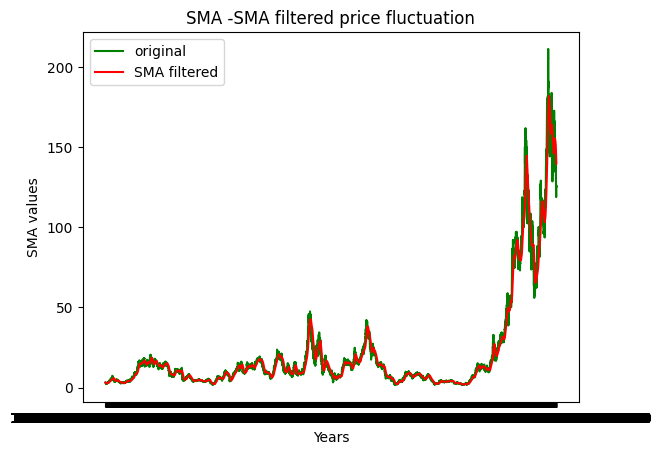

In [39]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=50
ticker="AMD" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="SMA" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="SMA"
sma_win = 50 #Re run
tuning=False
stock_file_name=f"{ticker}_data.csv"
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning)

The file 'AMD_data.csv' does exist.
Filter Name- SMA


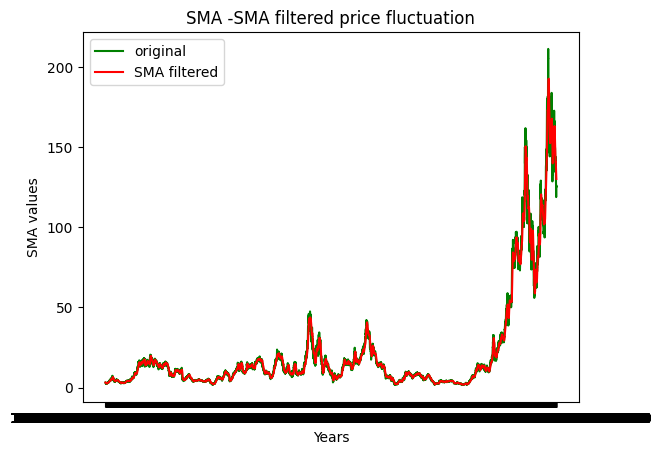

In [49]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=50
ticker="AMD" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="SMA" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="SMA"
sma_win = 20 #Re run
tuning=False
stock_file_name=f"{ticker}_data.csv"
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning)

The file 'AMD_data.csv' does exist.
Filter Name- SMA


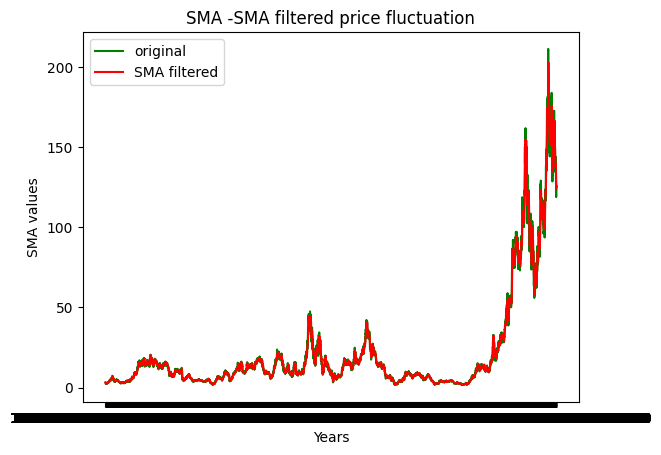

In [56]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=50
ticker="AMD" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="SMA" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="SMA"
sma_win = 10 #Re run
tuning=False
stock_file_name=f"{ticker}_data.csv"
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning)

##### After hyperparameter tuning - Train model with best values

In [41]:
win_size= 10#study_cnn.best_trial.params['win_size']
epoch_no= 100#study_cnn.best_trial.params['epoch_no']
drop_out= 0.4#round(study_cnn.best_trial.params['drop_out'],2)
units= 30#study_cnn.best_trial.params['units']
split_size= 0.4#round(study_cnn.best_trial.params['split_size'],2)
optimizer_options ='nadam'#study_cnn.best_trial.params['optimizer_name']
num_of_layers= 2#study_cnn.best_trial.params['no_layers']  
loss_option= 'log_cosh'#study_cnn.best_trial.params['loss_fn_name']
actv_option= 'gelu'#study_cnn.best_trial.params['activation_name']
filter_size= 64#study_cnn.best_trial.params['filter_size']
kernel_size= 3#study_cnn.best_trial.params['kernel_size']

best_model = build_model(win_size,drop_out,units,split_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))

unscaled X_train size (6768, 10)
scaled X_train size (6768, 10, 1) (6768,)
(10, 1)
Epoch 1/100
212/212 [==============================] - 10s 31ms/step - loss: 0.0884 - val_loss: 0.0020
Epoch 2/100
212/212 [==============================] - 6s 30ms/step - loss: 0.0177 - val_loss: 1.1069e-04
Epoch 3/100
212/212 [==============================] - 6s 30ms/step - loss: 0.0086 - val_loss: 5.8917e-05
Epoch 4/100
212/212 [==============================] - 6s 30ms/step - loss: 0.0054 - val_loss: 1.1805e-04
Epoch 5/100
212/212 [==============================] - 6s 30ms/step - loss: 0.0038 - val_loss: 8.2321e-05
Epoch 6/100
212/212 [==============================] - 6s 30ms/step - loss: 0.0031 - val_loss: 1.0232e-04
Epoch 7/100
212/212 [==============================] - 6s 30ms/step - loss: 0.0023 - val_loss: 9.6475e-05
Epoch 8/100
212/212 [==============================] - 6s 30ms/step - loss: 0.0021 - val_loss: 2.0312e-05
Epoch 9/100
212/212 [==============================] - 6s 30ms/step - lo

In [50]:
win_size= 10#study_cnn.best_trial.params['win_size']
epoch_no= 100#study_cnn.best_trial.params['epoch_no']
drop_out= 0.4#round(study_cnn.best_trial.params['drop_out'],2)
units= 30#study_cnn.best_trial.params['units']
split_size= 0.4#round(study_cnn.best_trial.params['split_size'],2)
optimizer_options ='nadam'#study_cnn.best_trial.params['optimizer_name']
num_of_layers= 2#study_cnn.best_trial.params['no_layers']  
loss_option= 'log_cosh'#study_cnn.best_trial.params['loss_fn_name']
actv_option= 'gelu'#study_cnn.best_trial.params['activation_name']
filter_size= 64#study_cnn.best_trial.params['filter_size']
kernel_size= 3#study_cnn.best_trial.params['kernel_size']

best_model = build_model(win_size,drop_out,units,split_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))

unscaled X_train size (6768, 10)
scaled X_train size (6768, 10, 1) (6768,)
(10, 1)
Epoch 1/100
212/212 [==============================] - 10s 30ms/step - loss: 0.1584 - val_loss: 0.0026
Epoch 2/100
212/212 [==============================] - 6s 27ms/step - loss: 0.0342 - val_loss: 3.3559e-04
Epoch 3/100
212/212 [==============================] - 6s 28ms/step - loss: 0.0148 - val_loss: 2.6825e-04
Epoch 4/100
212/212 [==============================] - 6s 27ms/step - loss: 0.0089 - val_loss: 6.7762e-05
Epoch 5/100
212/212 [==============================] - 6s 28ms/step - loss: 0.0062 - val_loss: 6.9449e-05
Epoch 6/100
212/212 [==============================] - 6s 28ms/step - loss: 0.0045 - val_loss: 1.2923e-04
Epoch 7/100
212/212 [==============================] - 6s 28ms/step - loss: 0.0033 - val_loss: 1.4322e-04
Epoch 8/100
212/212 [==============================] - 6s 28ms/step - loss: 0.0029 - val_loss: 6.0497e-05
Epoch 9/100
212/212 [==============================] - 6s 28ms/step - lo

In [57]:
win_size= 10#study_cnn.best_trial.params['win_size']
epoch_no= 100#study_cnn.best_trial.params['epoch_no']
drop_out= 0.4#round(study_cnn.best_trial.params['drop_out'],2)
units= 30#study_cnn.best_trial.params['units']
split_size= 0.4#round(study_cnn.best_trial.params['split_size'],2)
optimizer_options ='nadam'#study_cnn.best_trial.params['optimizer_name']
num_of_layers= 2#study_cnn.best_trial.params['no_layers']  
loss_option= 'log_cosh'#study_cnn.best_trial.params['loss_fn_name']
actv_option= 'gelu'#study_cnn.best_trial.params['activation_name']
filter_size= 64#study_cnn.best_trial.params['filter_size']
kernel_size= 3#study_cnn.best_trial.params['kernel_size']

best_model = build_model(win_size,drop_out,units,split_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))

unscaled X_train size (6768, 10)
scaled X_train size (6768, 10, 1) (6768,)
(10, 1)
Epoch 1/100
212/212 [==============================] - 11s 31ms/step - loss: 0.1659 - val_loss: 0.0017
Epoch 2/100
212/212 [==============================] - 6s 30ms/step - loss: 0.0356 - val_loss: 1.0424e-04
Epoch 3/100
212/212 [==============================] - 6s 29ms/step - loss: 0.0153 - val_loss: 7.4559e-05
Epoch 4/100
212/212 [==============================] - 6s 30ms/step - loss: 0.0084 - val_loss: 8.3257e-05
Epoch 5/100
212/212 [==============================] - 6s 30ms/step - loss: 0.0061 - val_loss: 6.3306e-05
Epoch 6/100
212/212 [==============================] - 6s 29ms/step - loss: 0.0045 - val_loss: 1.0167e-04
Epoch 7/100
212/212 [==============================] - 6s 29ms/step - loss: 0.0035 - val_loss: 4.9112e-05
Epoch 8/100
212/212 [==============================] - 6s 29ms/step - loss: 0.0029 - val_loss: 2.6342e-04
Epoch 9/100
212/212 [==============================] - 6s 30ms/step - lo

##### Evalute tuned model

In [44]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

71/71 [==============================] - 0s 7ms/step
**********************SMA filter***************************
Mean Absolute Percentage Error (MAPE): 0.30%
Mean Absolute Error (MAE): 30.77
Root Mean Squared Error (RMSE): 47.54
R2 Score: 0.13


In [51]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

71/71 [==============================] - 1s 6ms/step
**********************SMA filter***************************
Mean Absolute Percentage Error (MAPE): 0.23%
Mean Absolute Error (MAE): 23.94
Root Mean Squared Error (RMSE): 37.83
R2 Score: 0.46


In [58]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

71/71 [==============================] - 1s 7ms/step
**********************SMA filter***************************
Mean Absolute Percentage Error (MAPE): 0.25%
Mean Absolute Error (MAE): 26.80
Root Mean Squared Error (RMSE): 42.24
R2 Score: 0.32


##### Validation and training loss plot

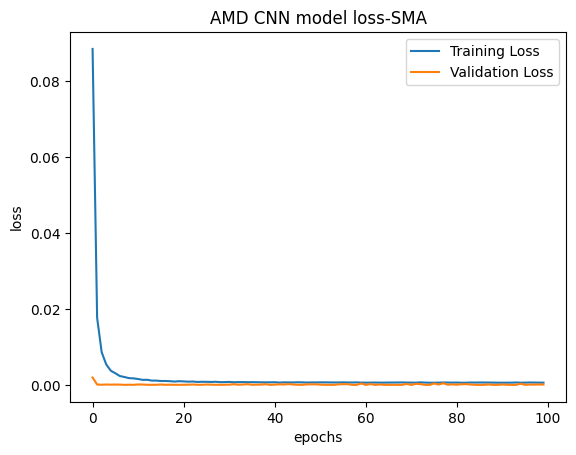

In [ ]:
#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} RNN model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

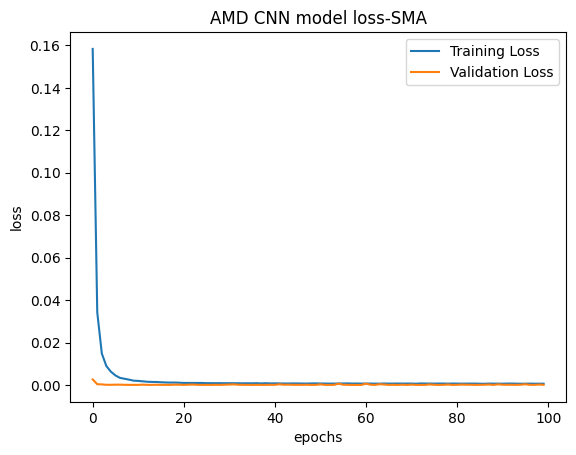

In [52]:
#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} RNN model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

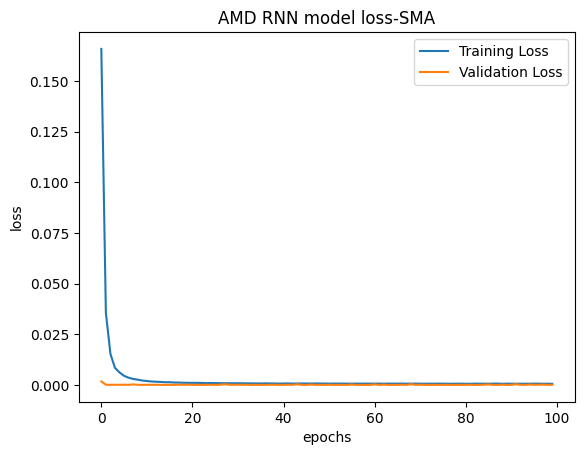

In [59]:
#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} RNN model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

##### Save model

In [55]:
# Save the entire model as a `.keras` zip archive.
# best_model.save('TSLA_model_hyperparameter.keras')
best_model.save(f'saved_model_RNN/{ticker}_model_{study_naam}_{sma_win}')
# Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

INFO:tensorflow:Assets written to: saved_model_RNN/AMD_model_SMA_20/assets


INFO:tensorflow:Assets written to: saved_model_RNN/AMD_model_SMA_20/assets


In [ ]:
best_model.summary()

##### Load model

In [ ]:
new_model = tf.keras.models.load_model('TSLA_model_hyperparameter.keras')

##### Plot 

In [48]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="RNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


In [53]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="RNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


In [60]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="RNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


#### AMD - Filtered(kalman)

##### Start Tuning

The file 'AMD_data.csv' does exist.
Filter Name- kalman


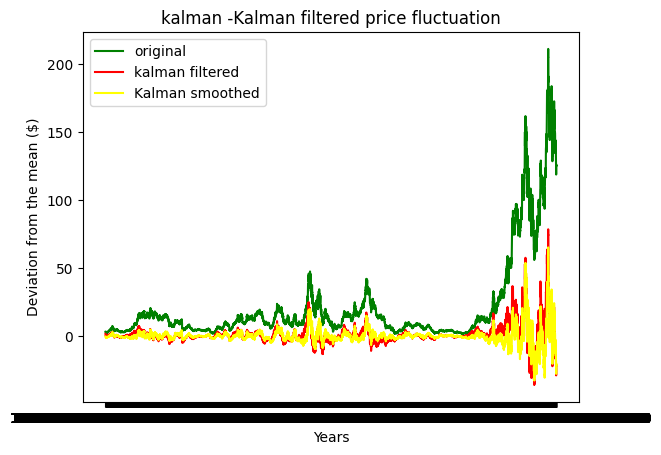

In [61]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=2
ticker="AMD" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="kalman" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="kalman"
tuning=False
stock_file_name=f"{ticker}_data.csv"
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning)

##### After hyperparameter tuning - Evaluate model with best values

In [62]:
win_size= 10#study_cnn.best_trial.params['win_size']
epoch_no= 100#study_cnn.best_trial.params['epoch_no']
drop_out= 0.4#round(study_cnn.best_trial.params['drop_out'],2)
units= 30#study_cnn.best_trial.params['units']
split_size= 0.4#round(study_cnn.best_trial.params['split_size'],2)
optimizer_options ='nadam'#study_cnn.best_trial.params['optimizer_name']
num_of_layers= 2#study_cnn.best_trial.params['no_layers']  
loss_option= 'log_cosh'#study_cnn.best_trial.params['loss_fn_name']
actv_option= 'gelu'#study_cnn.best_trial.params['activation_name']
filter_size= 64#study_cnn.best_trial.params['filter_size']
kernel_size= 3#study_cnn.best_trial.params['kernel_size']
best_model = build_model(win_size,drop_out,units,split_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))

unscaled X_train size (6768, 10)
scaled X_train size (6768, 10, 1) (6768,)
(10, 1)
Epoch 1/100
212/212 [==============================] - 10s 32ms/step - loss: 0.2075 - val_loss: 0.0142
Epoch 2/100
212/212 [==============================] - 7s 31ms/step - loss: 0.0459 - val_loss: 0.0035
Epoch 3/100
212/212 [==============================] - 6s 29ms/step - loss: 0.0140 - val_loss: 5.1257e-04
Epoch 4/100
212/212 [==============================] - 6s 30ms/step - loss: 0.0061 - val_loss: 7.8628e-05
Epoch 5/100
212/212 [==============================] - 6s 29ms/step - loss: 0.0038 - val_loss: 8.7207e-05
Epoch 6/100
212/212 [==============================] - 6s 29ms/step - loss: 0.0028 - val_loss: 7.3240e-05
Epoch 7/100
212/212 [==============================] - 6s 29ms/step - loss: 0.0022 - val_loss: 5.5906e-05
Epoch 8/100
212/212 [==============================] - 6s 29ms/step - loss: 0.0018 - val_loss: 6.6316e-05
Epoch 9/100
212/212 [==============================] - 6s 30ms/step - loss: 

##### Evaluate trained model

In [63]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

71/71 [==============================] - 1s 7ms/step
**********************kalman filter***************************
Mean Absolute Percentage Error (MAPE): 4.22%
Mean Absolute Error (MAE): 2.36
Root Mean Squared Error (RMSE): 4.51
R2 Score: 0.90


##### Val and training loss plot

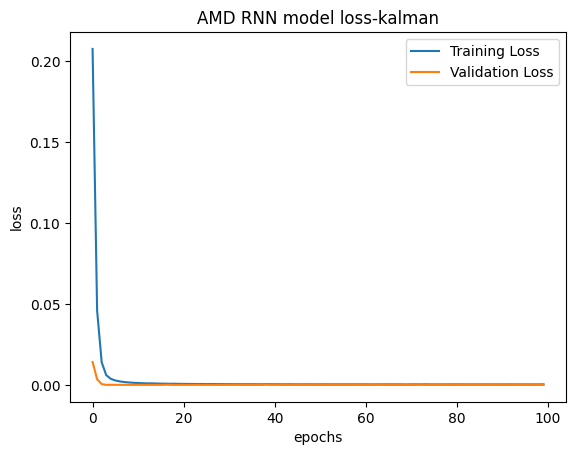

In [64]:
#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} RNN model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

##### Save model

In [65]:
# Save the entire model as a `.keras` zip archive.
# best_model.save('TSLA_model_hyperparameter.keras')
best_model.save(f'saved_model_LSTM/{ticker}_model_{study_naam}')
# Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

INFO:tensorflow:Assets written to: saved_model_LSTM/AMD_model_kalman/assets


INFO:tensorflow:Assets written to: saved_model_LSTM/AMD_model_kalman/assets


In [ ]:
best_model.summary()

##### Load model

In [ ]:
new_model = tf.keras.models.load_model('TSLA_model_hyperparameter.keras')

##### Plot 

In [66]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="RNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


#### AMD - Filtered(EMA)

##### Start Tuning

The file 'AMD_data.csv' does exist.
Filter Name- EMA


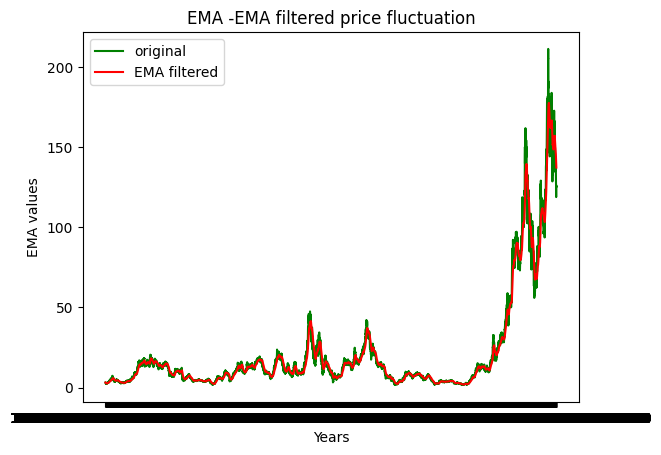

In [67]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
ema_win=50
n_trial=2
ticker="AMD" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="EMA" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="EMA"
tuning=False
stock_file_name=f"{ticker}_data.csv"
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning)

The file 'AMD_data.csv' does exist.
Filter Name- EMA


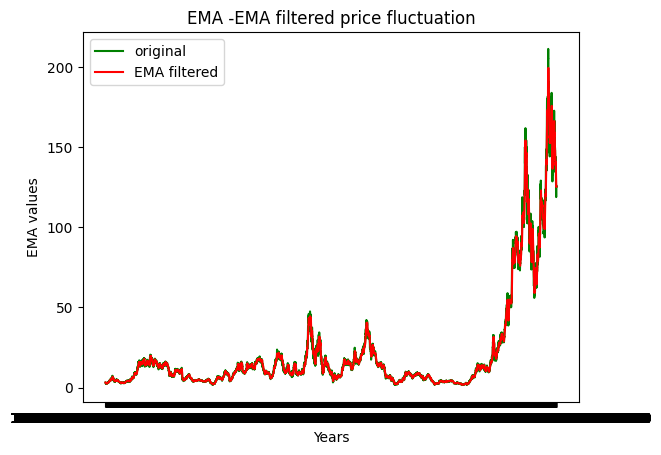

In [73]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
ema_win=10
n_trial=2
ticker="AMD" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="EMA" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="EMA"
tuning=False
stock_file_name=f"{ticker}_data.csv"
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning)

##### After hyperparameter tuning - Evaluate model with best values

In [68]:
win_size= 10#study_cnn.best_trial.params['win_size']
epoch_no= 100#study_cnn.best_trial.params['epoch_no']
drop_out= 0.4#round(study_cnn.best_trial.params['drop_out'],2)
units= 30#study_cnn.best_trial.params['units']
split_size= 0.4#round(study_cnn.best_trial.params['split_size'],2)
optimizer_options ='nadam'#study_cnn.best_trial.params['optimizer_name']
num_of_layers= 2#study_cnn.best_trial.params['no_layers']  
loss_option= 'mean_squared_error'#study_cnn.best_trial.params['loss_fn_name']
actv_option= 'gelu'#study_cnn.best_trial.params['activation_name']
filter_size= 64#study_cnn.best_trial.params['filter_size']
kernel_size= 3#study_cnn.best_trial.params['kernel_size']
# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))

unscaled X_train size (6768, 10)
scaled X_train size (6768, 10, 1) (6768,)
(10, 1)
Epoch 1/100


2025-01-01 13:29:40.073929: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-01-01 13:29:40.074655: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-01-01 13:29:40.074702: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-01-01 13:29:40.074884: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before

212/212 [==============================] - 10s 31ms/step - loss: 0.3580 - val_loss: 0.0044
Epoch 2/100
212/212 [==============================] - 6s 29ms/step - loss: 0.0792 - val_loss: 8.3950e-04
Epoch 3/100
212/212 [==============================] - 6s 29ms/step - loss: 0.0344 - val_loss: 5.4261e-04
Epoch 4/100
212/212 [==============================] - 6s 29ms/step - loss: 0.0203 - val_loss: 4.7242e-04
Epoch 5/100
212/212 [==============================] - 6s 30ms/step - loss: 0.0139 - val_loss: 4.0033e-04
Epoch 6/100
212/212 [==============================] - 6s 29ms/step - loss: 0.0106 - val_loss: 9.4309e-05
Epoch 7/100
212/212 [==============================] - 6s 29ms/step - loss: 0.0083 - val_loss: 1.7028e-04
Epoch 8/100
212/212 [==============================] - 6s 29ms/step - loss: 0.0067 - val_loss: 5.4935e-04
Epoch 9/100
212/212 [==============================] - 6s 29ms/step - loss: 0.0056 - val_loss: 6.1163e-05
Epoch 10/100
212/212 [==============================] - 6s 29

In [74]:
win_size= 10#study_cnn.best_trial.params['win_size']
epoch_no= 100#study_cnn.best_trial.params['epoch_no']
drop_out= 0.4#round(study_cnn.best_trial.params['drop_out'],2)
units= 30#study_cnn.best_trial.params['units']
split_size= 0.4#round(study_cnn.best_trial.params['split_size'],2)
optimizer_options ='nadam'#study_cnn.best_trial.params['optimizer_name']
num_of_layers= 2#study_cnn.best_trial.params['no_layers']  
loss_option= 'mean_squared_error'#study_cnn.best_trial.params['loss_fn_name']
actv_option= 'gelu'#study_cnn.best_trial.params['activation_name']

# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))

unscaled X_train size (6768, 10)
scaled X_train size (6768, 10, 1) (6768,)
(10, 1)
Epoch 1/100
212/212 [==============================] - 11s 31ms/step - loss: 0.3533 - val_loss: 0.0078
Epoch 2/100
212/212 [==============================] - 6s 29ms/step - loss: 0.0811 - val_loss: 0.0022
Epoch 3/100
212/212 [==============================] - 6s 29ms/step - loss: 0.0351 - val_loss: 3.9458e-04
Epoch 4/100
212/212 [==============================] - 6s 29ms/step - loss: 0.0210 - val_loss: 3.2646e-04
Epoch 5/100
212/212 [==============================] - 6s 29ms/step - loss: 0.0146 - val_loss: 2.4978e-04
Epoch 6/100
212/212 [==============================] - 6s 29ms/step - loss: 0.0106 - val_loss: 3.0342e-04
Epoch 7/100
212/212 [==============================] - 6s 29ms/step - loss: 0.0082 - val_loss: 7.9702e-05
Epoch 8/100
212/212 [==============================] - 6s 29ms/step - loss: 0.0064 - val_loss: 1.3054e-04
Epoch 9/100
212/212 [==============================] - 6s 29ms/step - loss: 

win_size=80

In [78]:
win_size= 80#study_cnn.best_trial.params['win_size']
epoch_no= 100#study_cnn.best_trial.params['epoch_no']
drop_out= 0.4#round(study_cnn.best_trial.params['drop_out'],2)
units= 30#study_cnn.best_trial.params['units']
split_size= 0.4#round(study_cnn.best_trial.params['split_size'],2)
optimizer_options ='nadam'#study_cnn.best_trial.params['optimizer_name']
num_of_layers= 2#study_cnn.best_trial.params['no_layers']  
loss_option= 'mean_squared_error'#study_cnn.best_trial.params['loss_fn_name']
actv_option= 'gelu'#study_cnn.best_trial.params['activation_name']

# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))

unscaled X_train size (6726, 80)
scaled X_train size (6726, 80, 1) (6726,)
(80, 1)
Epoch 1/100
211/211 [==============================] - 33s 139ms/step - loss: 0.3987 - val_loss: 0.0027
Epoch 2/100
211/211 [==============================] - 29s 137ms/step - loss: 0.0866 - val_loss: 0.0012
Epoch 3/100
211/211 [==============================] - 29s 138ms/step - loss: 0.0377 - val_loss: 2.7408e-04
Epoch 4/100
211/211 [==============================] - 29s 138ms/step - loss: 0.0223 - val_loss: 1.0053e-04
Epoch 5/100
211/211 [==============================] - 29s 137ms/step - loss: 0.0145 - val_loss: 1.4287e-04
Epoch 6/100
211/211 [==============================] - 28s 134ms/step - loss: 0.0100 - val_loss: 8.5762e-05
Epoch 7/100
211/211 [==============================] - 28s 133ms/step - loss: 0.0081 - val_loss: 2.1526e-04
Epoch 8/100
211/211 [==============================] - 28s 134ms/step - loss: 0.0065 - val_loss: 1.3919e-04
Epoch 9/100
211/211 [==============================] - 28s 13

##### Evaluate trained model

In [69]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

71/71 [==============================] - 1s 7ms/step
**********************EMA filter***************************
Mean Absolute Percentage Error (MAPE): 0.29%
Mean Absolute Error (MAE): 31.53
Root Mean Squared Error (RMSE): 48.55
R2 Score: 0.08


In [75]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

71/71 [==============================] - 1s 6ms/step
**********************EMA filter***************************
Mean Absolute Percentage Error (MAPE): 0.27%
Mean Absolute Error (MAE): 26.22
Root Mean Squared Error (RMSE): 40.31
R2 Score: 0.38


In [79]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

71/71 [==============================] - 2s 25ms/step
**********************EMA filter***************************
Mean Absolute Percentage Error (MAPE): 0.28%
Mean Absolute Error (MAE): 29.07
Root Mean Squared Error (RMSE): 46.16
R2 Score: 0.19


##### Val and training loss plot

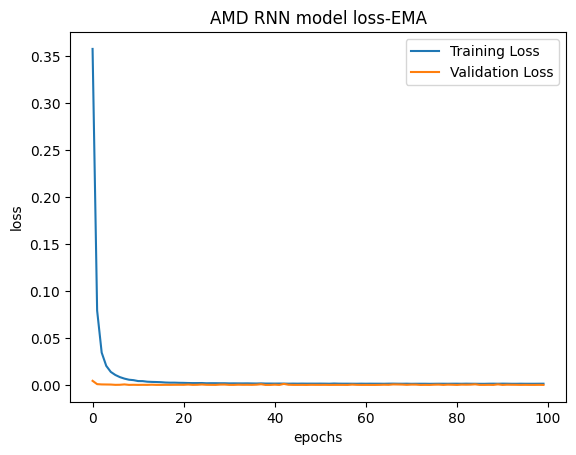

In [70]:

#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} RNN model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

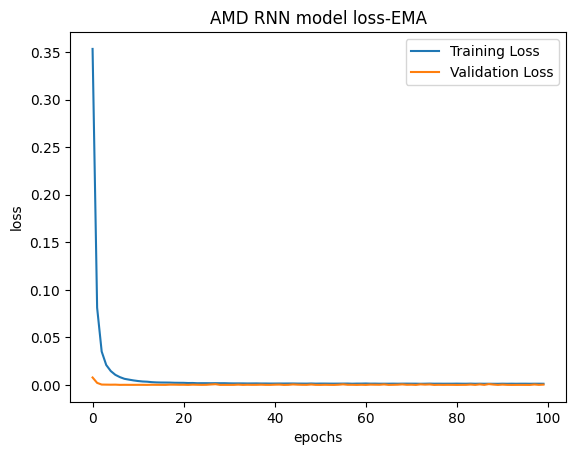

In [76]:

#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} RNN model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

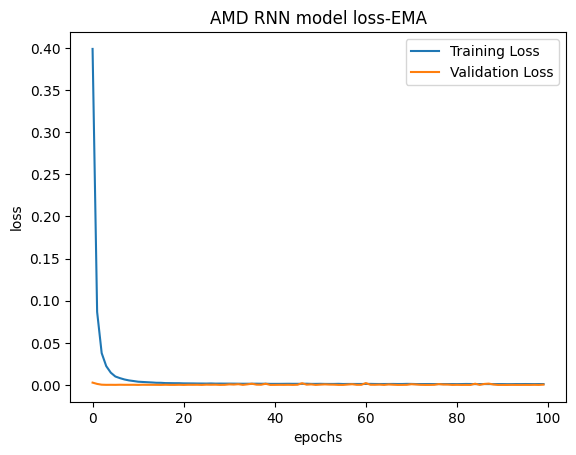

In [80]:

#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} RNN model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

##### Save model

In [82]:
# Save the entire model as a `.keras` zip archive.
best_model.save(f'saved_model_RNN/{ticker}_model_{study_naam}_{ema_win}')

# Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

INFO:tensorflow:Assets written to: saved_model_RNN/AMD_model_EMA_10/assets


INFO:tensorflow:Assets written to: saved_model_RNN/AMD_model_EMA_10/assets


In [ ]:
best_model.summary()

##### Load model

In [ ]:
new_model = tf.keras.models.load_model('TSLA_model_hyperparameter.keras')

##### Plot 

In [72]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="RNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


In [77]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="RNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


In [81]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="RNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


#### TSLA - Filtered(MACD)

##### Start Tuning

In [ ]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=2
ticker="TSLA" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="MACD" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="MACD"
abc(ticker,n_trial,filter,f"{study_naam}",batch_size_no,attn)

##### Optuna plot

In [ ]:
optuna.visualization.plot_optimization_history(study_rnn)

In [ ]:
# optuna-dashboard sqlite:///db.sqlite3

optuna.visualization.plot_slice(study_rnn)

##### Best parameter values

In [ ]:
study_rnn.best_trial.params

##### After hyperparameter tuning - Evaluate model with best values

In [ ]:
win_size=study_rnn.best_trial.params['win_size']
pred_step=10
epoch_no=study_rnn.best_trial.params['epoch_no']
batch_size_no=32
split_size=round(study_rnn.best_trial.params['split_size'],2)
attn=False
units=study_rnn.best_trial.params['units']
drop_out=round(study_rnn.best_trial.params['drop_out'],2)
n_trial=0
best_model = build_model(win_size,drop_out,units,split_size)
# print(f"**********************{study_naam} filter*************************")

scaled_data_unfilt = scaler.transform(tesla_data[['Close']].values)
X_unfilt,y_unfilt = create_sequences(scaled_data_unfilt,study_rnn.best_trial.params['win_size'])
X_test_unfilt = X_unfilt[-len(X_test):]
y_test_unfilt = y_unfilt[-len(y_test):]

history = best_model.fit(X_train, y_train, epochs=epoch_no, batch_size=32, validation_data=(X_test_unfilt, y_test_unfilt))
# abc("TSLA",win_size,pred_step,units,drop_out,n_trial,epoch_no,batch_size_no,split_size,attn)

##### Evaluate trained model

In [ ]:
evaluate_model(best_model,X_test_unfilt,y_test_unfilt, filter)

##### Val and training loss plot

In [ ]:
#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

##### Save model

In [ ]:
# Save the entire model as a `.keras` zip archive.
best_model.save(f'TSLA_model_hyperparameter_{filter}.keras')

# Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

In [ ]:
best_model.summary()

##### Load model

In [ ]:
new_model = tf.keras.models.load_model('TSLA_model_hyperparameter.keras')

##### Plot 

In [ ]:
if attn:
    a = "attention"
else:
    a = ""

print("****************************TEST************************************")
model_name="rnn"
plot_simple(tesla_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,y_raw, predicted_stock_price_raw,10,6)
plot_interative(tesla_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,y_raw, predicted_stock_price_raw)

#### AMD - Filtered(Fourier)

##### Start Tuning

The file 'AMD_data.csv' does exist.
freq- [ 0.00000000e+00  8.85661146e-05  1.77132229e-04 ... -2.65698344e-04
 -1.77132229e-04 -8.85661146e-05]
amp- [240325.29968715 102109.49488886 131204.85275027 ...  97117.10320762
 131204.85275027 102109.49488886]


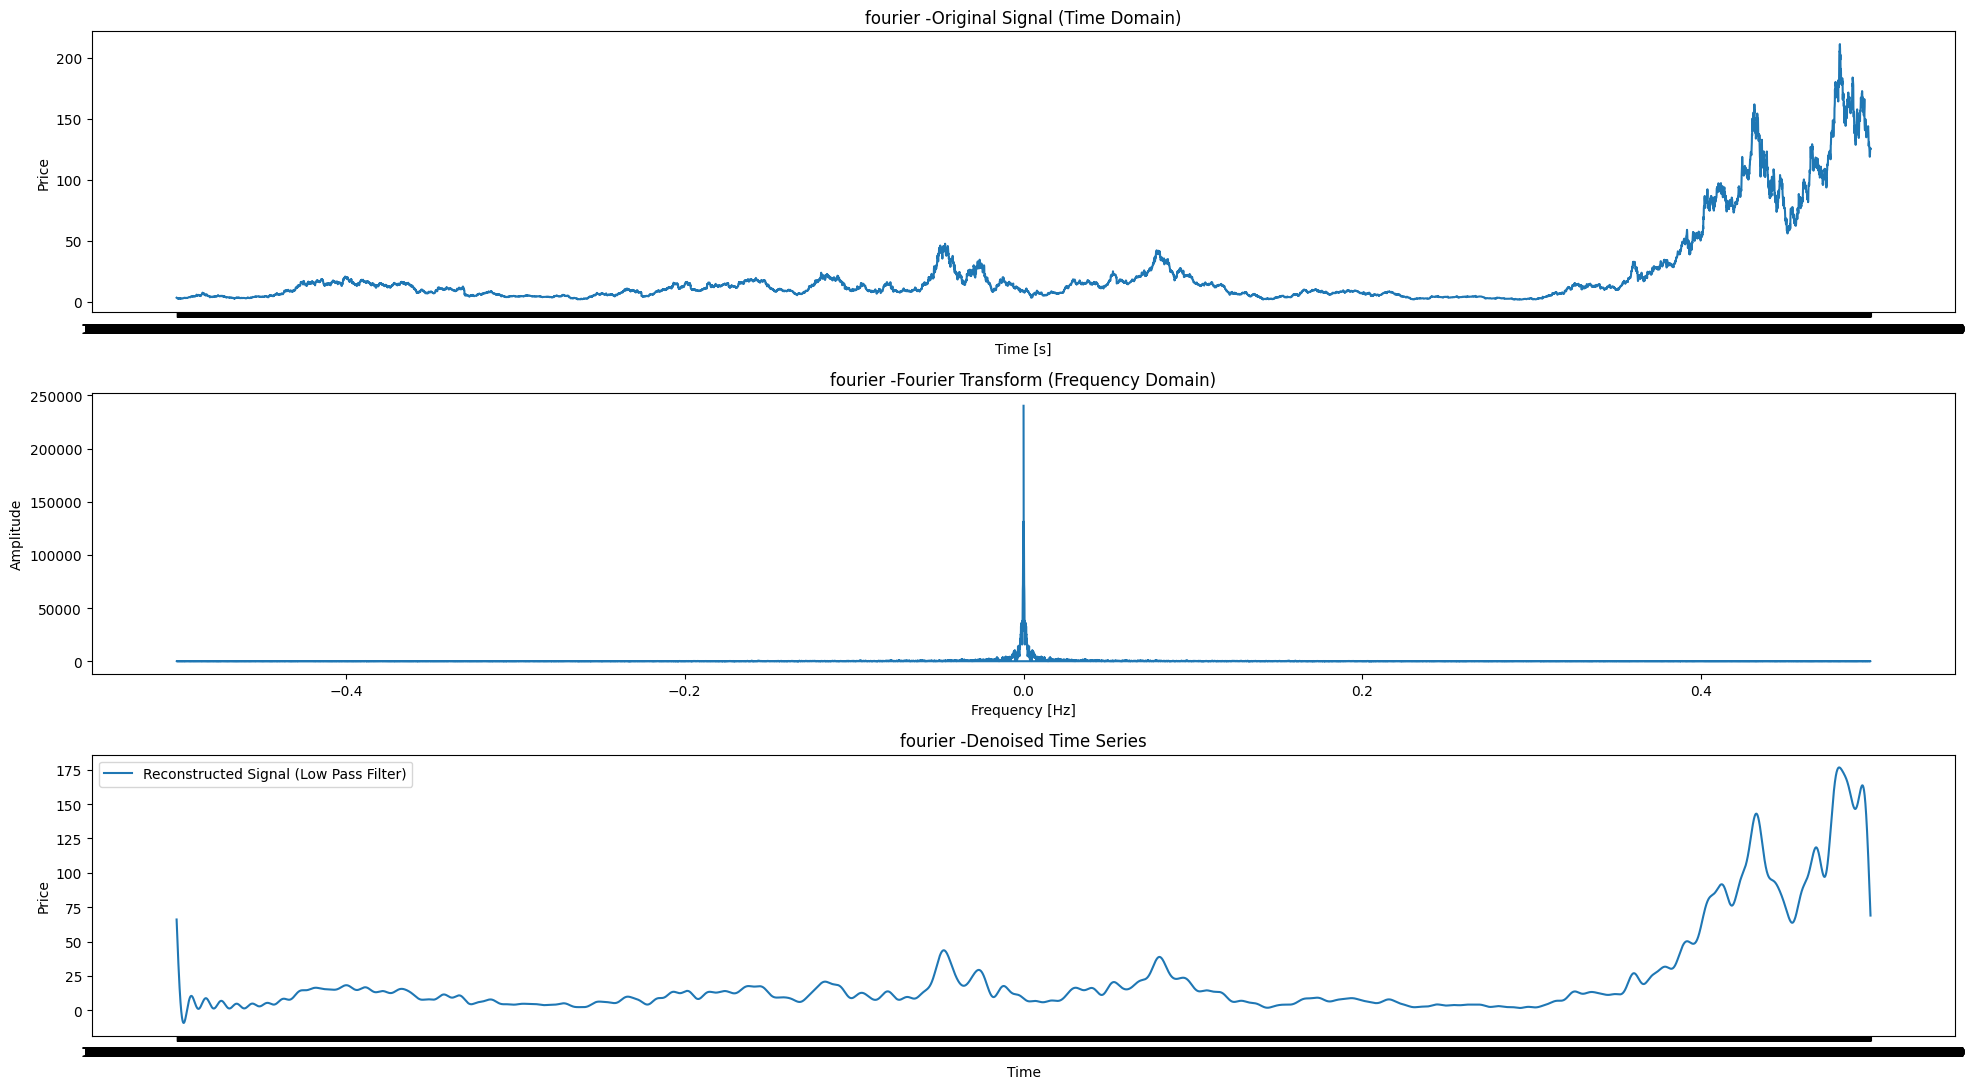

Filter Name- fourier


In [83]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=2
threshold = 0.01 #0.2, 0.1, 0.05, 0.01, 0.005, 0.001
ticker="AMD" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="fourier" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="fourier"
tuning=False
stock_file_name=f"{ticker}_data.csv"
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning)

The file 'AMD_data.csv' does exist.
freq- [ 0.00000000e+00  8.85661146e-05  1.77132229e-04 ... -2.65698344e-04
 -1.77132229e-04 -8.85661146e-05]
amp- [240325.29968715 102109.49488886 131204.85275027 ...  97117.10320762
 131204.85275027 102109.49488886]


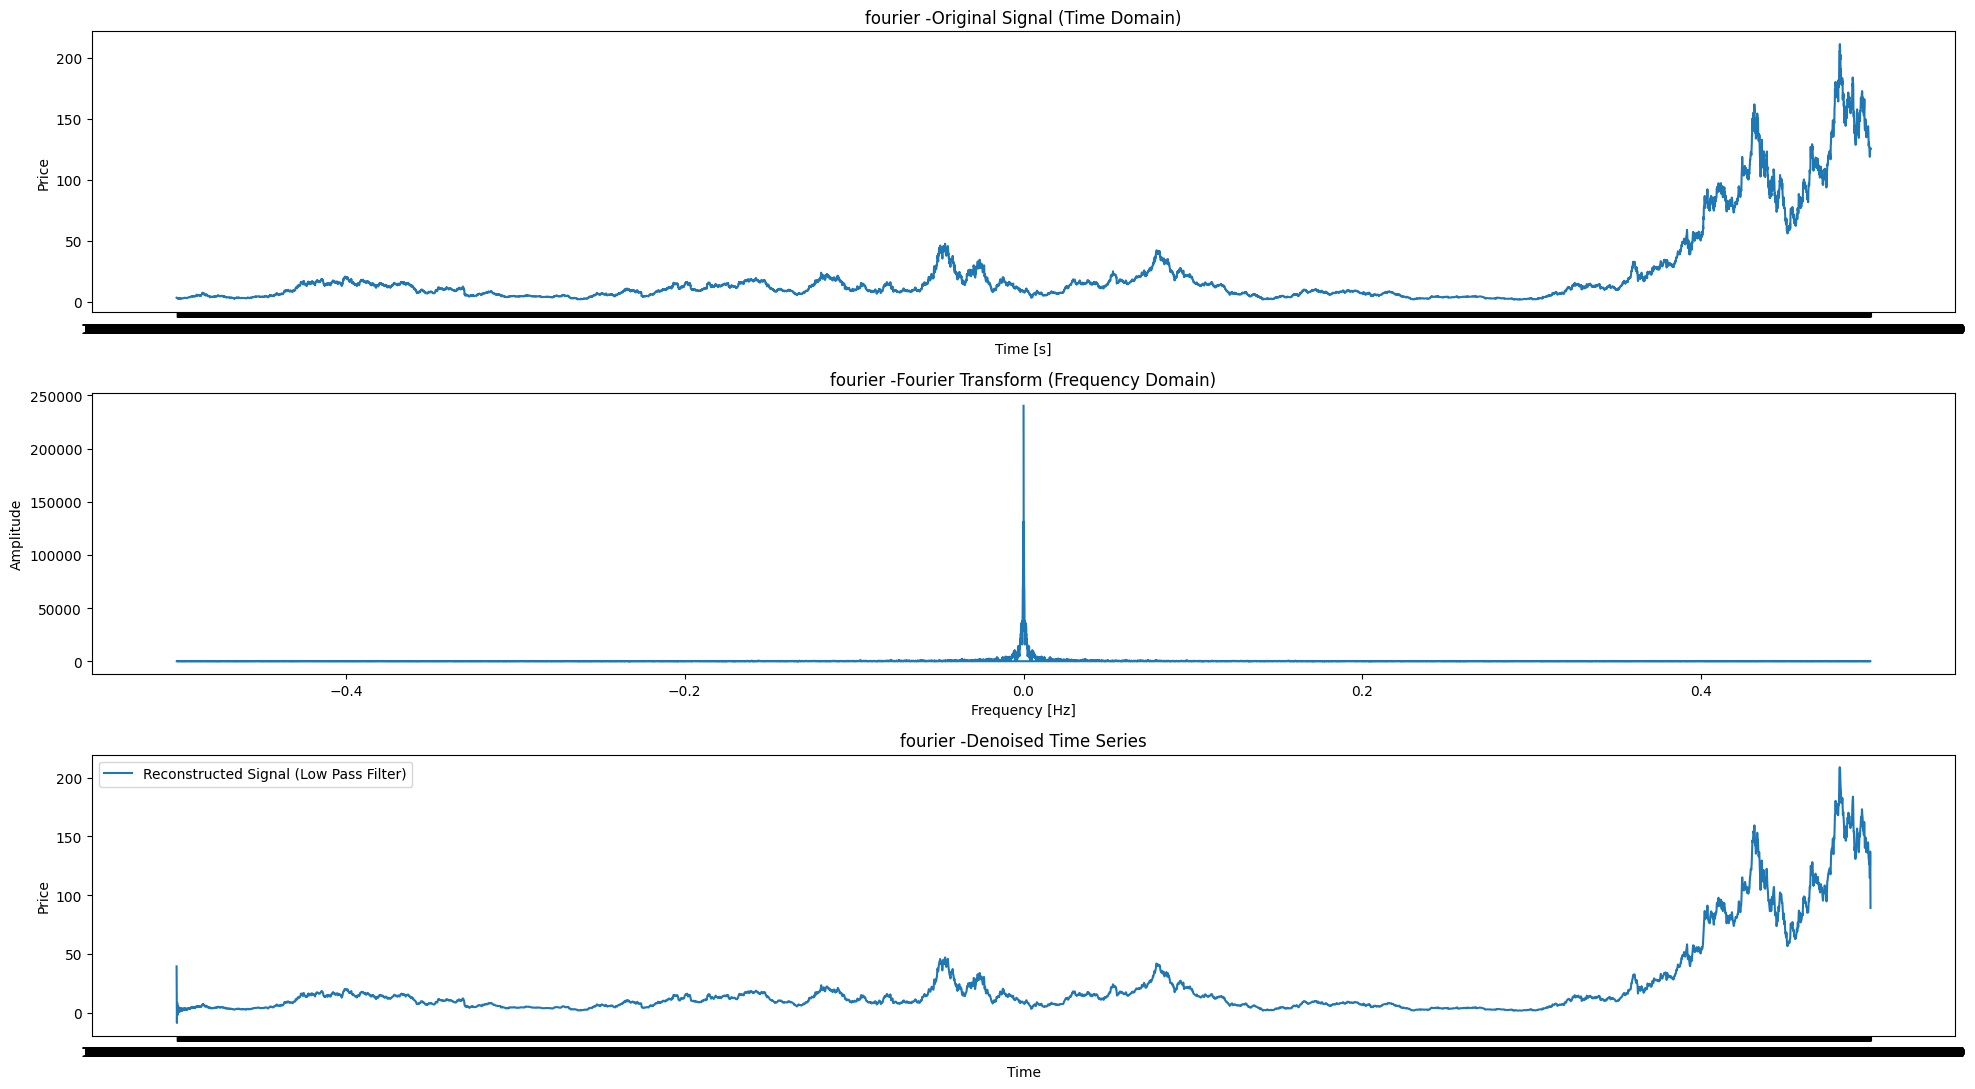

Filter Name- fourier


In [91]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=2
threshold = 0.2 #0.2, 0.1, 0.05, 0.01, 0.005, 0.001
ticker="AMD" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="fourier" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="fourier"
tuning=False
stock_file_name=f"{ticker}_data.csv"
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning)

The file 'AMD_data.csv' does exist.
freq- [ 0.00000000e+00  8.85661146e-05  1.77132229e-04 ... -2.65698344e-04
 -1.77132229e-04 -8.85661146e-05]
amp- [240325.29968715 102109.49488886 131204.85275027 ...  97117.10320762
 131204.85275027 102109.49488886]


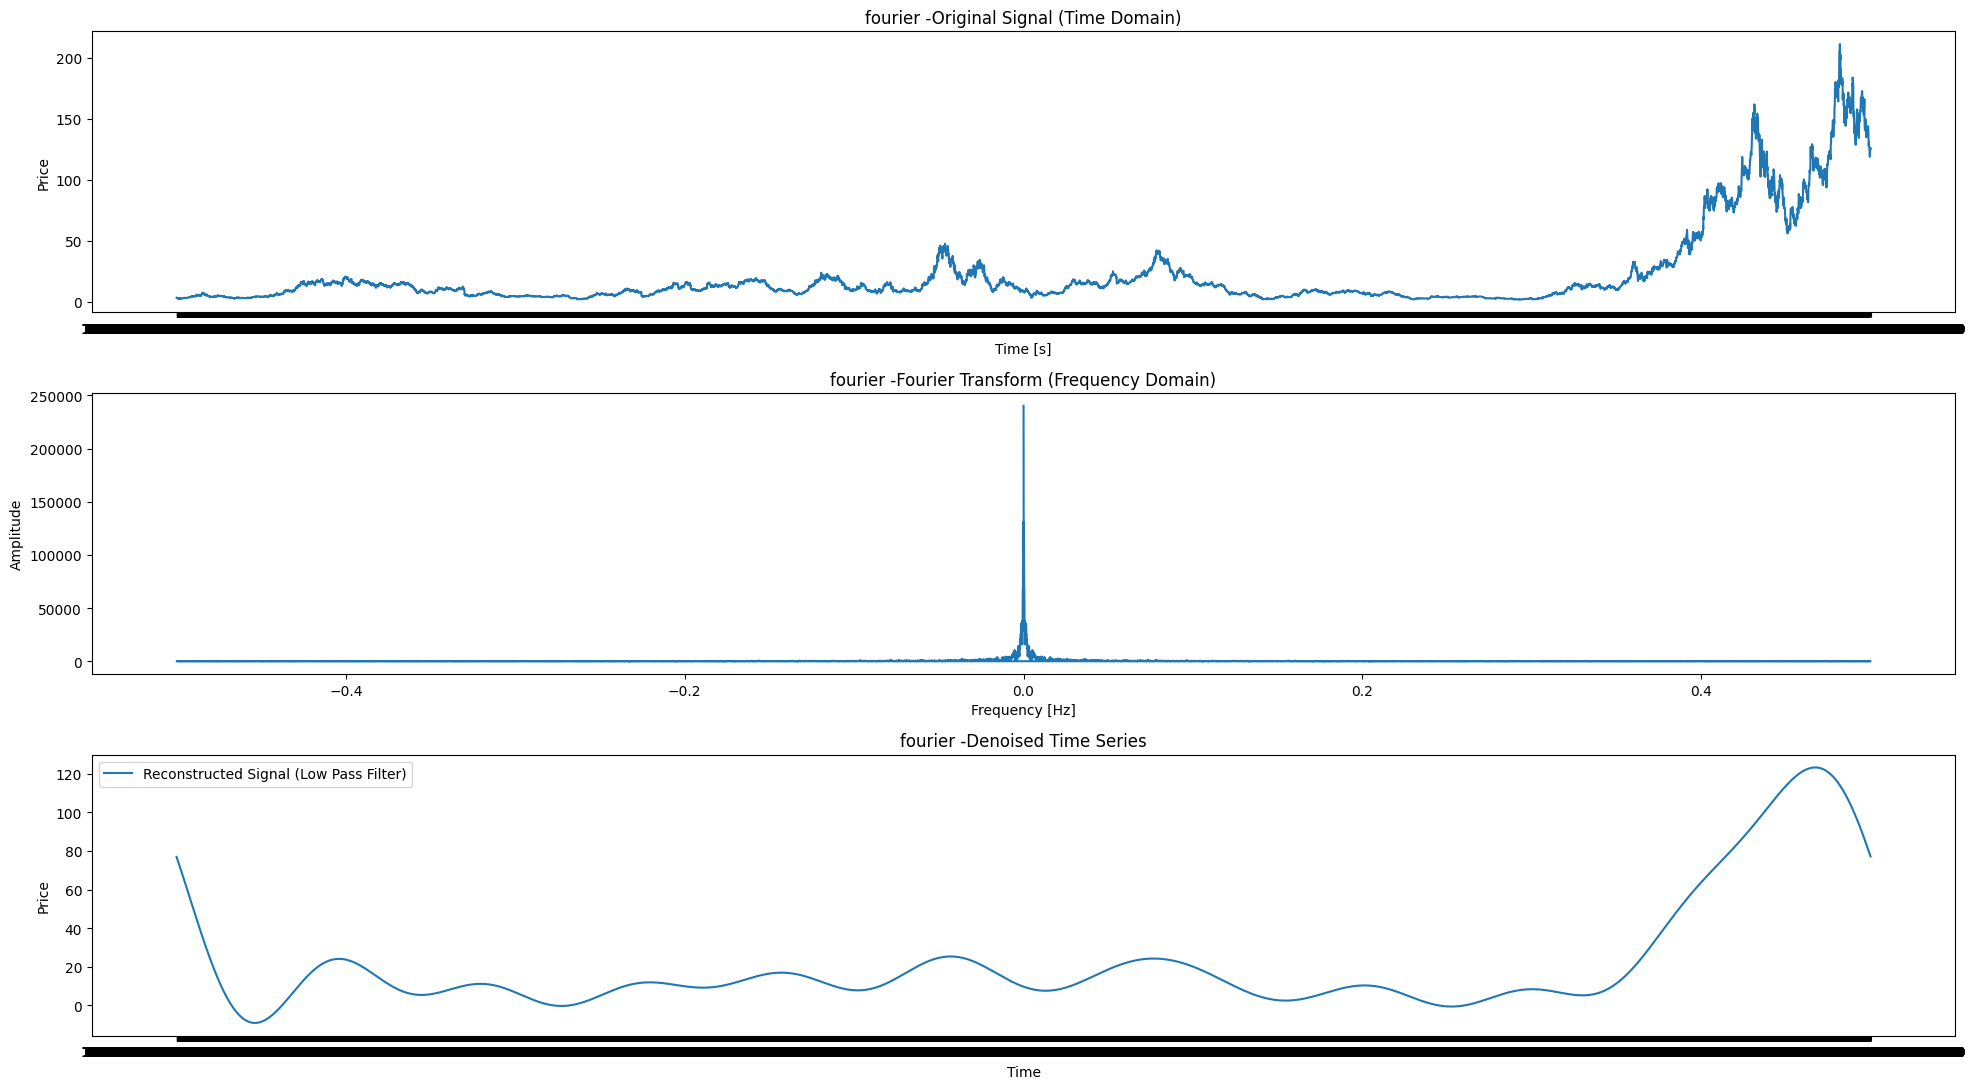

Filter Name- fourier


In [97]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=2
threshold = 0.001 #0.2, 0.1, 0.05, 0.01, 0.005, 0.001
ticker="AMD" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="fourier" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="fourier"
tuning=False
stock_file_name=f"{ticker}_data.csv"
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning)

##### After hyperparameter tuning - Train model with best values

In [84]:
win_size= 10#study_cnn.best_trial.params['win_size']
epoch_no= 100#study_cnn.best_trial.params['epoch_no']
drop_out= 0.4#round(study_cnn.best_trial.params['drop_out'],2)
units= 30#study_cnn.best_trial.params['units']
split_size= 0.4#round(study_cnn.best_trial.params['split_size'],2)
optimizer_options ='nadam'#study_cnn.best_trial.params['optimizer_name']
num_of_layers= 2#study_cnn.best_trial.params['no_layers']  
loss_option= 'mean_squared_error'#study_cnn.best_trial.params['loss_fn_name']
actv_option= 'gelu'#study_cnn.best_trial.params['activation_name']

# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))

unscaled X_train size (6768, 10)
scaled X_train size (6768, 10, 1) (6768,)
(10, 1)
Epoch 1/100
212/212 [==============================] - 10s 32ms/step - loss: 0.5647 - val_loss: 0.0040
Epoch 2/100
212/212 [==============================] - 6s 29ms/step - loss: 0.1214 - val_loss: 0.0026
Epoch 3/100
212/212 [==============================] - 6s 30ms/step - loss: 0.0437 - val_loss: 0.0014
Epoch 4/100
212/212 [==============================] - 6s 30ms/step - loss: 0.0223 - val_loss: 2.6507e-04
Epoch 5/100
212/212 [==============================] - 6s 29ms/step - loss: 0.0150 - val_loss: 1.8984e-04
Epoch 6/100
212/212 [==============================] - 6s 29ms/step - loss: 0.0109 - val_loss: 2.4085e-04
Epoch 7/100
212/212 [==============================] - 6s 29ms/step - loss: 0.0080 - val_loss: 1.8836e-04
Epoch 8/100
212/212 [==============================] - 6s 29ms/step - loss: 0.0066 - val_loss: 6.9676e-05
Epoch 9/100
212/212 [==============================] - 6s 29ms/step - loss: 0.00

In [92]:
win_size= 10#study_cnn.best_trial.params['win_size']
epoch_no= 100#study_cnn.best_trial.params['epoch_no']
drop_out= 0.4#round(study_cnn.best_trial.params['drop_out'],2)
units= 30#study_cnn.best_trial.params['units']
split_size= 0.4#round(study_cnn.best_trial.params['split_size'],2)
optimizer_options ='nadam'#study_cnn.best_trial.params['optimizer_name']
num_of_layers= 2#study_cnn.best_trial.params['no_layers']  
loss_option= 'mean_squared_error'#study_cnn.best_trial.params['loss_fn_name']
actv_option= 'gelu'#study_cnn.best_trial.params['activation_name']

# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))

unscaled X_train size (6768, 10)
scaled X_train size (6768, 10, 1) (6768,)
(10, 1)
Epoch 1/100
212/212 [==============================] - 10s 31ms/step - loss: 0.2609 - val_loss: 0.0043
Epoch 2/100
212/212 [==============================] - 6s 30ms/step - loss: 0.0615 - val_loss: 0.0019
Epoch 3/100
212/212 [==============================] - 6s 30ms/step - loss: 0.0265 - val_loss: 0.0016
Epoch 4/100
212/212 [==============================] - 6s 30ms/step - loss: 0.0148 - val_loss: 9.1698e-04
Epoch 5/100
212/212 [==============================] - 6s 30ms/step - loss: 0.0101 - val_loss: 9.2257e-05
Epoch 6/100
212/212 [==============================] - 6s 30ms/step - loss: 0.0072 - val_loss: 1.2004e-04
Epoch 7/100
212/212 [==============================] - 6s 30ms/step - loss: 0.0061 - val_loss: 9.1740e-05
Epoch 8/100
212/212 [==============================] - 6s 30ms/step - loss: 0.0051 - val_loss: 1.3671e-04
Epoch 9/100
212/212 [==============================] - 6s 30ms/step - loss: 0.00

In [98]:
win_size= 10#study_cnn.best_trial.params['win_size']
epoch_no= 100#study_cnn.best_trial.params['epoch_no']
drop_out= 0.4#round(study_cnn.best_trial.params['drop_out'],2)
units= 30#study_cnn.best_trial.params['units']
split_size= 0.4#round(study_cnn.best_trial.params['split_size'],2)
optimizer_options ='nadam'#study_cnn.best_trial.params['optimizer_name']
num_of_layers= 2#study_cnn.best_trial.params['no_layers']  
loss_option= 'mean_squared_error'#study_cnn.best_trial.params['loss_fn_name']
actv_option= 'gelu'#study_cnn.best_trial.params['activation_name']

# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))

unscaled X_train size (6768, 10)
scaled X_train size (6768, 10, 1) (6768,)
(10, 1)
Epoch 1/100
212/212 [==============================] - 10s 30ms/step - loss: 0.4689 - val_loss: 0.0054
Epoch 2/100
212/212 [==============================] - 6s 28ms/step - loss: 0.0894 - val_loss: 6.1693e-04
Epoch 3/100
212/212 [==============================] - 6s 28ms/step - loss: 0.0331 - val_loss: 5.6782e-04
Epoch 4/100
212/212 [==============================] - 6s 28ms/step - loss: 0.0175 - val_loss: 4.0438e-05
Epoch 5/100
212/212 [==============================] - 6s 28ms/step - loss: 0.0121 - val_loss: 6.0546e-05
Epoch 6/100
212/212 [==============================] - 6s 28ms/step - loss: 0.0088 - val_loss: 5.4892e-05
Epoch 7/100
212/212 [==============================] - 6s 28ms/step - loss: 0.0071 - val_loss: 9.5102e-05
Epoch 8/100
212/212 [==============================] - 6s 28ms/step - loss: 0.0054 - val_loss: 7.8457e-05
Epoch 9/100
212/212 [==============================] - 6s 28ms/step - lo

##### Evaluate trained model

In [90]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

71/71 [==============================] - 0s 6ms/step
**********************fourier filter***************************
Mean Absolute Percentage Error (MAPE): 0.28%
Mean Absolute Error (MAE): 26.56
Root Mean Squared Error (RMSE): 40.42
R2 Score: 0.37


In [93]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

71/71 [==============================] - 1s 6ms/step
**********************fourier filter***************************
Mean Absolute Percentage Error (MAPE): 0.31%
Mean Absolute Error (MAE): 31.49
Root Mean Squared Error (RMSE): 49.22
R2 Score: 0.08


In [99]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

71/71 [==============================] - 1s 7ms/step
**********************fourier filter***************************
Mean Absolute Percentage Error (MAPE): 0.12%
Mean Absolute Error (MAE): 9.71
Root Mean Squared Error (RMSE): 14.56
R2 Score: 0.89


##### Val and training loss plot

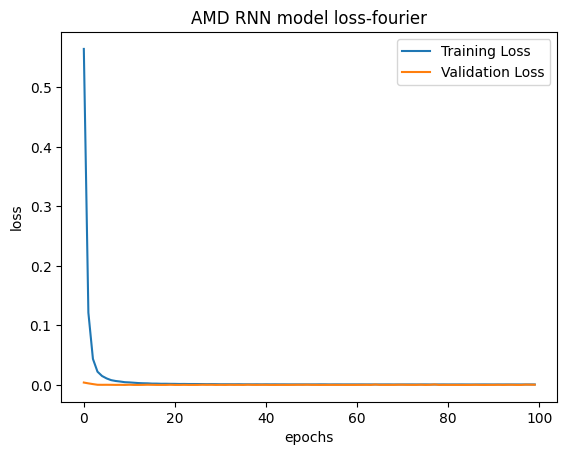

In [86]:

#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} RNN model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

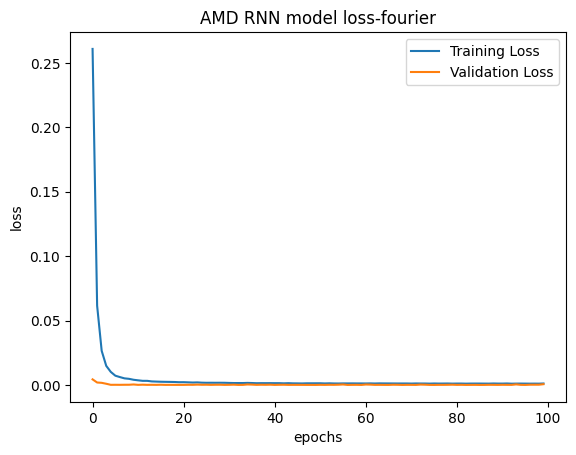

In [94]:

#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} RNN model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

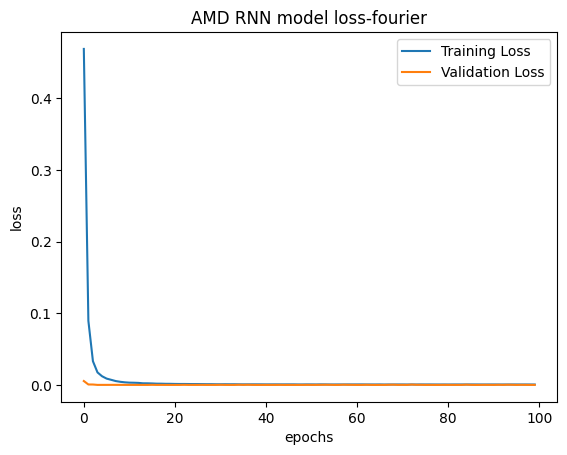

In [100]:

#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} RNN model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

##### Save model

In [101]:
# Save the entire model as a `.keras` zip archive.
best_model.save(f'saved_model_RNN/{ticker}_model_{study_naam}_{threshold}')

# Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

INFO:tensorflow:Assets written to: saved_model_RNN/AMD_model_fourier_0.001/assets


INFO:tensorflow:Assets written to: saved_model_RNN/AMD_model_fourier_0.001/assets


In [88]:
best_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_32 (SimpleRNN)   (None, 10, 30)            960       
                                                                 
 dropout_32 (Dropout)        (None, 10, 30)            0         
                                                                 
 simple_rnn_33 (SimpleRNN)   (None, 10, 30)            1830      
                                                                 
 dropout_33 (Dropout)        (None, 10, 30)            0         
                                                                 
 simple_rnn_34 (SimpleRNN)   (None, 10, 30)            1830      
                                                                 
 dropout_34 (Dropout)        (None, 10, 30)            0         
                                                                 
 simple_rnn_35 (SimpleRNN)   (None, 30)               

##### Load model

In [ ]:
new_model = tf.keras.models.load_model('TSLA_model_hyperparameter.keras')

##### Plot 

In [89]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="RNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


In [96]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="RNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


In [102]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="RNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


#### AMD - Filtered(Wavelet)

##### Start Tuning

The file 'AMD_data.csv' does exist.
length of details- 7
Threshold enabled- False


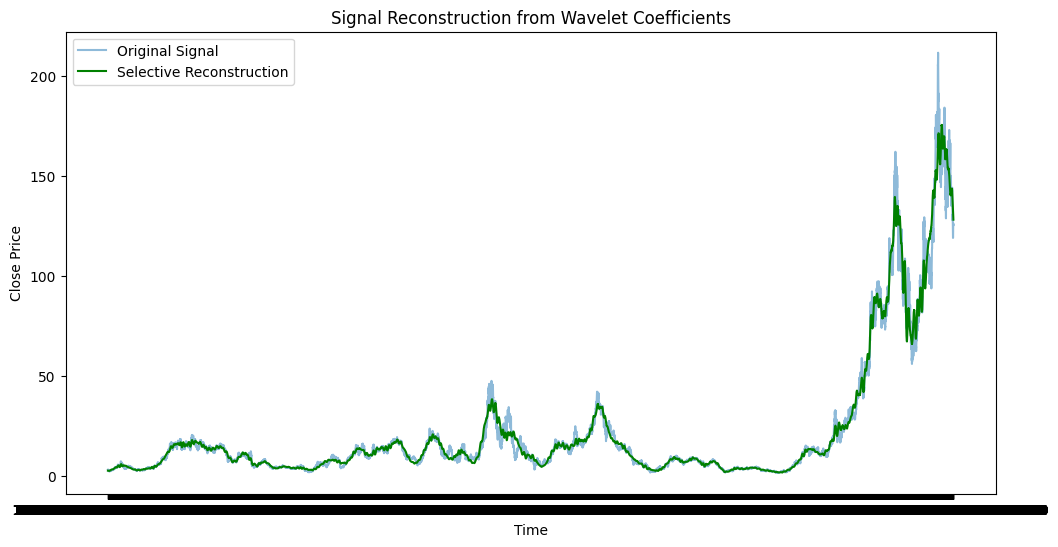

Filter Name- wavelet


In [105]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=2
ticker="AMD" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="wavelet" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="wavelet"
tuning=False
stock_file_name=f"{ticker}_data.csv"
detail_index=2
#'haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dmey', 'gaus',
# 'mexh', 'morl', 'cgau', 'shan', 'fbsp', 'cmor'
wavelet_name="dmey"
approx_enable=False
threshold_enable=False
thresh_value=0
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning,detail_index,wavelet_name,approx_enable,threshold_enable,thresh_value)

The file 'AMD_data.csv' does exist.
length of details- 7
Threshold enabled- False


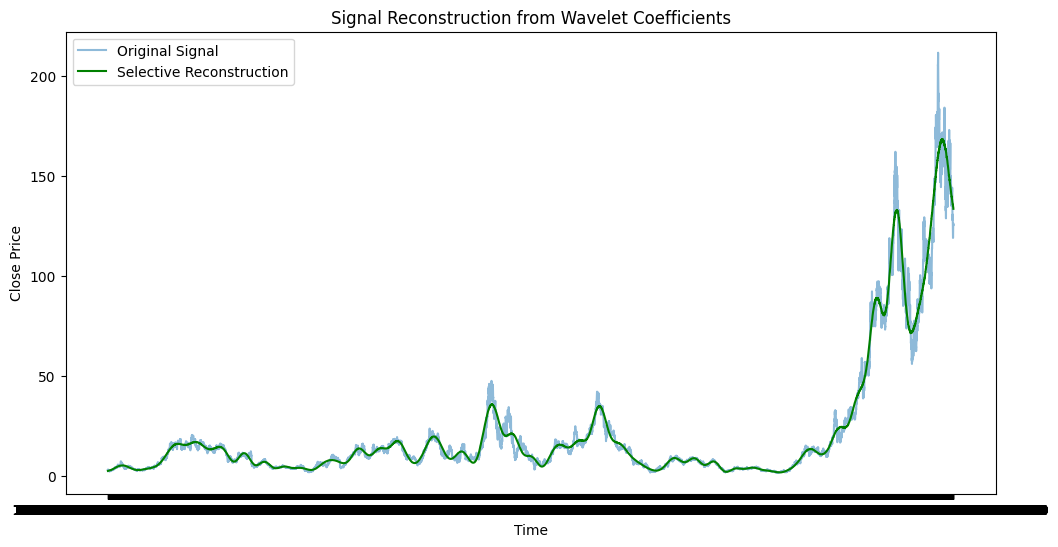

Filter Name- wavelet


In [111]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=2
ticker="AMD" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="wavelet" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="wavelet"
tuning=False
stock_file_name=f"{ticker}_data.csv"
detail_index=7
#'haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dmey', 'gaus',
# 'mexh', 'morl', 'cgau', 'shan', 'fbsp', 'cmor'
wavelet_name="dmey"
approx_enable=False
threshold_enable=False
thresh_value=0
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning,detail_index,wavelet_name,approx_enable,threshold_enable,thresh_value)

The file 'AMD_data.csv' does exist.
length of details- 8
Threshold enabled- False


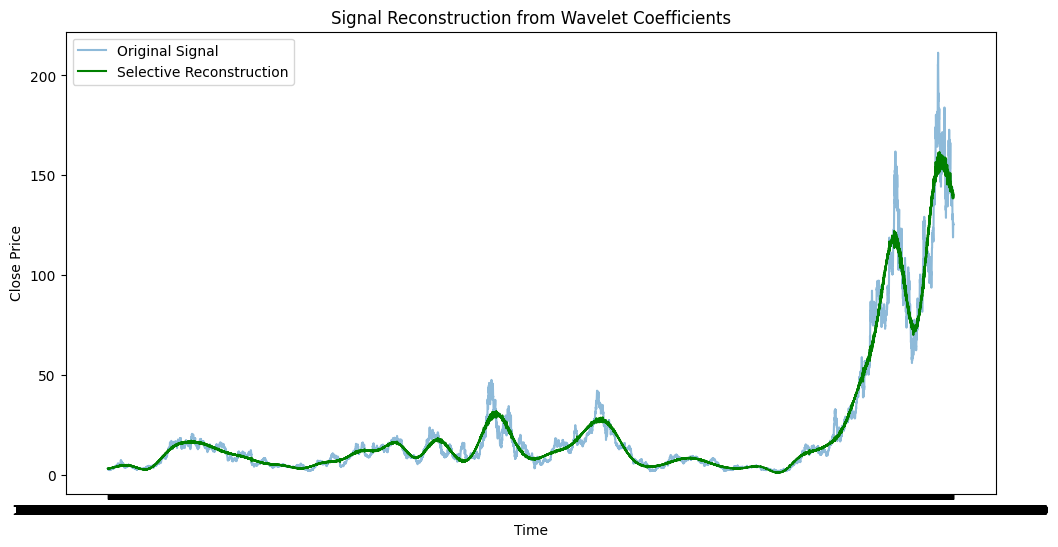

Filter Name- wavelet


In [117]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=2
ticker="AMD" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="wavelet" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="wavelet"
tuning=False
stock_file_name=f"{ticker}_data.csv"
detail_index=7
#'haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dmey', 'gaus',
# 'mexh', 'morl', 'cgau', 'shan', 'fbsp', 'cmor'
wavelet_name="sym18"
approx_enable=False
threshold_enable=False
thresh_value=0
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning,detail_index,wavelet_name,approx_enable,threshold_enable,thresh_value)

In [ ]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=2
ticker="AMD" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="wavelet" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="wavelet"
tuning=False
stock_file_name=f"{ticker}_data.csv"
detail_index=3
#'haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dmey', 'gaus',
# 'mexh', 'morl', 'cgau', 'shan', 'fbsp', 'cmor'
wavelet_name="sym18"
approx_enable=False
threshold_enable=False
thresh_value=0
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning,detail_index,wavelet_name,approx_enable,threshold_enable,thresh_value)

##### After hyperparameter tuning - Train model with best values

In [106]:
win_size= 10#study_cnn.best_trial.params['win_size']
epoch_no= 100#study_cnn.best_trial.params['epoch_no']
drop_out= 0.4#round(study_cnn.best_trial.params['drop_out'],2)
units= 30#study_cnn.best_trial.params['units']
split_size= 0.4#round(study_cnn.best_trial.params['split_size'],2)
optimizer_options ='nadam'#study_cnn.best_trial.params['optimizer_name']
num_of_layers= 2#study_cnn.best_trial.params['no_layers']  
loss_option= 'mean_squared_error'#study_cnn.best_trial.params['loss_fn_name']
actv_option= 'gelu'#study_cnn.best_trial.params['activation_name']

# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))

unscaled X_train size (6769, 10)
scaled X_train size (6769, 10, 1) (6769,)
(10, 1)
Epoch 1/100
212/212 [==============================] - 10s 32ms/step - loss: 0.3016 - val_loss: 0.0166
Epoch 2/100
212/212 [==============================] - 6s 31ms/step - loss: 0.0783 - val_loss: 0.0027
Epoch 3/100
212/212 [==============================] - 6s 31ms/step - loss: 0.0368 - val_loss: 0.0011
Epoch 4/100
212/212 [==============================] - 6s 30ms/step - loss: 0.0218 - val_loss: 4.8359e-04
Epoch 5/100
212/212 [==============================] - 6s 30ms/step - loss: 0.0144 - val_loss: 2.0046e-04
Epoch 6/100
212/212 [==============================] - 6s 30ms/step - loss: 0.0112 - val_loss: 1.8620e-04
Epoch 7/100
212/212 [==============================] - 6s 30ms/step - loss: 0.0085 - val_loss: 1.4050e-04
Epoch 8/100
212/212 [==============================] - 6s 29ms/step - loss: 0.0066 - val_loss: 2.5778e-04
Epoch 9/100
212/212 [==============================] - 6s 30ms/step - loss: 0.00

In [112]:
win_size= 10#study_cnn.best_trial.params['win_size']
epoch_no= 100#study_cnn.best_trial.params['epoch_no']
drop_out= 0.4#round(study_cnn.best_trial.params['drop_out'],2)
units= 30#study_cnn.best_trial.params['units']
split_size= 0.4#round(study_cnn.best_trial.params['split_size'],2)
optimizer_options ='nadam'#study_cnn.best_trial.params['optimizer_name']
num_of_layers= 2#study_cnn.best_trial.params['no_layers']  
loss_option= 'mean_squared_error'#study_cnn.best_trial.params['loss_fn_name']
actv_option= 'gelu'#study_cnn.best_trial.params['activation_name']

# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))

unscaled X_train size (6769, 10)
scaled X_train size (6769, 10, 1) (6769,)
(10, 1)
Epoch 1/100
212/212 [==============================] - 10s 32ms/step - loss: 0.3570 - val_loss: 0.0086
Epoch 2/100
212/212 [==============================] - 7s 31ms/step - loss: 0.0911 - val_loss: 0.0018
Epoch 3/100
212/212 [==============================] - 7s 31ms/step - loss: 0.0405 - val_loss: 0.0014
Epoch 4/100
212/212 [==============================] - 7s 31ms/step - loss: 0.0248 - val_loss: 2.0563e-04
Epoch 5/100
212/212 [==============================] - 7s 31ms/step - loss: 0.0166 - val_loss: 5.0576e-04
Epoch 6/100
212/212 [==============================] - 7s 31ms/step - loss: 0.0126 - val_loss: 9.4232e-05
Epoch 7/100
212/212 [==============================] - 7s 31ms/step - loss: 0.0090 - val_loss: 1.0248e-04
Epoch 8/100
212/212 [==============================] - 7s 31ms/step - loss: 0.0078 - val_loss: 8.6323e-05
Epoch 9/100
212/212 [==============================] - 7s 31ms/step - loss: 0.00

In [118]:
win_size= 100#study_cnn.best_trial.params['win_size']
epoch_no= 100#study_cnn.best_trial.params['epoch_no']
drop_out= 0.4#round(study_cnn.best_trial.params['drop_out'],2)
units= 30#study_cnn.best_trial.params['units']
split_size= 0.4#round(study_cnn.best_trial.params['split_size'],2)
optimizer_options ='adam'#study_cnn.best_trial.params['optimizer_name']
num_of_layers= 2#study_cnn.best_trial.params['no_layers']  
loss_option= 'mean_squared_error'#study_cnn.best_trial.params['loss_fn_name']
actv_option= 'gelu'#study_cnn.best_trial.params['activation_name']

# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))

unscaled X_train size (6715, 100)
scaled X_train size (6715, 100, 1) (6715,)
(100, 1)
Epoch 1/100


2025-01-01 19:51:54.565524: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-01-01 19:51:54.616548: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-01-01 19:51:54.692214: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



210/210 [==============================] - 38s 167ms/step - loss: 0.4959 - val_loss: 0.0074
Epoch 2/100
210/210 [==============================] - 35s 165ms/step - loss: 0.1235 - val_loss: 0.0050
Epoch 3/100
210/210 [==============================] - 35s 166ms/step - loss: 0.0531 - val_loss: 0.0019
Epoch 4/100
210/210 [==============================] - 35s 167ms/step - loss: 0.0300 - val_loss: 4.6736e-04
Epoch 5/100
210/210 [==============================] - 35s 167ms/step - loss: 0.0195 - val_loss: 0.0012
Epoch 6/100
210/210 [==============================] - 35s 165ms/step - loss: 0.0138 - val_loss: 7.9960e-04
Epoch 7/100
210/210 [==============================] - 34s 164ms/step - loss: 0.0106 - val_loss: 5.3070e-04
Epoch 8/100
210/210 [==============================] - 35s 165ms/step - loss: 0.0084 - val_loss: 0.0014
Epoch 9/100
210/210 [==============================] - 35s 165ms/step - loss: 0.0072 - val_loss: 6.7447e-04
Epoch 10/100
210/210 [==============================] - 35s 

##### Evaluate trained model

In [107]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

71/71 [==============================] - 1s 7ms/step
**********************wavelet filter***************************
Mean Absolute Percentage Error (MAPE): 0.35%
Mean Absolute Error (MAE): 34.44
Root Mean Squared Error (RMSE): 51.24
R2 Score: -0.01


In [113]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

71/71 [==============================] - 1s 7ms/step
**********************wavelet filter***************************
Mean Absolute Percentage Error (MAPE): 0.35%
Mean Absolute Error (MAE): 37.77
Root Mean Squared Error (RMSE): 56.35
R2 Score: -0.23


In [119]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

70/70 [==============================] - 2s 30ms/step
**********************wavelet filter***************************
Mean Absolute Percentage Error (MAPE): 0.40%
Mean Absolute Error (MAE): 41.73
Root Mean Squared Error (RMSE): 60.37
R2 Score: -0.47


##### Val and training loss plot

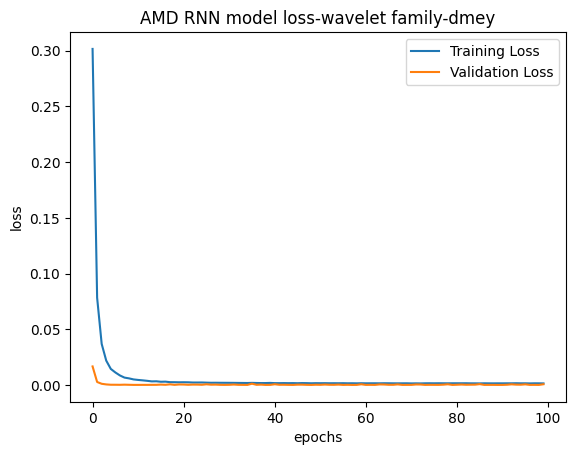

In [108]:

#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} RNN model loss-{study_naam} family-{wavelet_name}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

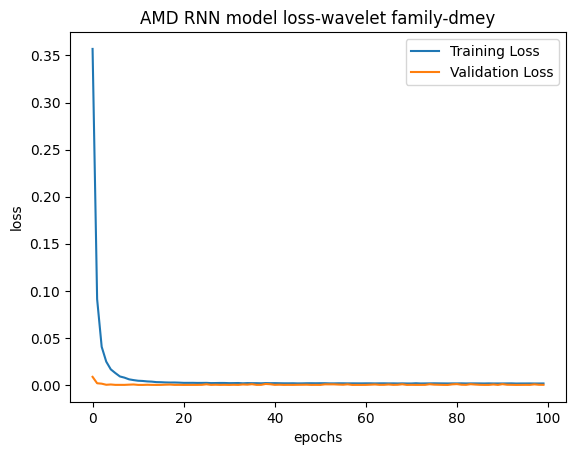

In [114]:

#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} RNN model loss-{study_naam} family-{wavelet_name}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

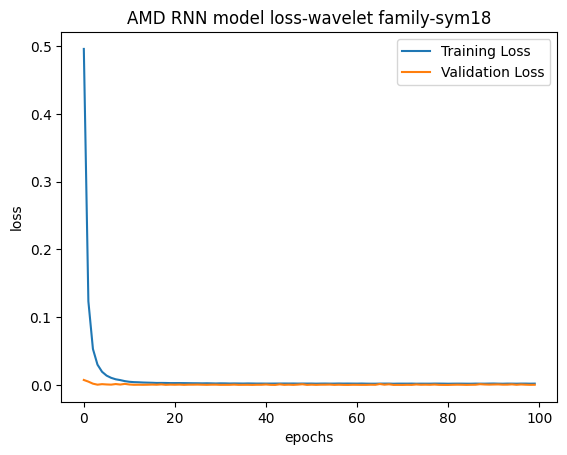

In [120]:

#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} RNN model loss-{study_naam} family-{wavelet_name}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

##### Save model

In [121]:
# Save the entire model as a `.keras` zip archive.
best_model.save(f'saved_model_RNN/{ticker}_model_{study_naam}_{wavelet_name}({detail_index})')

# Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

INFO:tensorflow:Assets written to: saved_model_RNN/AMD_model_wavelet_sym18(7)/assets


INFO:tensorflow:Assets written to: saved_model_RNN/AMD_model_wavelet_sym18(7)/assets


In [ ]:
best_model.summary()

##### Load model

In [ ]:
new_model = tf.keras.models.load_model('TSLA_model_hyperparameter.keras')

##### Plot 

In [110]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="RNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


In [116]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="RNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


In [122]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="RNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


#### TSLA - Filtered(MSTL)

##### Start Tuning

In [ ]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=2
ticker="TSLA" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="mstl" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="mstl"
detail_index=0
wavelet_name="db4"
approx_enable=True
threshold_enable=False
thresh_value=0
mstl_period=[7]
abc(ticker,n_trial,filter,study_naam,batch_size_no,attn,detail_index,wavelet_name,approx_enable,threshold_enable,thresh_value,mstl_period)

##### Optuna plot

In [ ]:
optuna.visualization.plot_optimization_history(study_rnn)

In [ ]:
# optuna-dashboard sqlite:///db.sqlite3

optuna.visualization.plot_slice(study_rnn)

##### Best parameter values

In [ ]:
study_rnn.best_trial.params

##### After hyperparameter tuning - Train model with best values

In [ ]:
win_size=study_rnn.best_trial.params['win_size']
pred_step=10
epoch_no=study_rnn.best_trial.params['epoch_no']
batch_size_no=32
split_size=round(study_rnn.best_trial.params['split_size'],2)
attn=False
units=study_rnn.best_trial.params['units']
drop_out=round(study_rnn.best_trial.params['drop_out'],2)
n_trial=0
best_model = build_model(win_size,drop_out,units,split_size)
# print(f"**********************{study_naam} filter*************************")

scaled_data_unfilt = scaler.transform(tesla_data[['Close']].values)
X_unfilt,y_unfilt = create_sequences(scaled_data_unfilt,study_rnn.best_trial.params['win_size'])
X_test_unfilt = X_unfilt[-len(X_test):]
y_test_unfilt = y_unfilt[-len(y_test):]

history = best_model.fit(X_train, y_train, epochs=epoch_no, batch_size=32, validation_data=(X_test_unfilt, y_test_unfilt))
# abc("TSLA",win_size,pred_step,units,drop_out,n_trial,epoch_no,batch_size_no,split_size,attn)

##### Evaluate trained model

In [51]:
X_test_unfilt.shape

(719, 40)

In [52]:
type(X_test_unfilt)

numpy.ndarray

In [ ]:
X_test_unfilt

In [ ]:
# scaled_data_org = scaler.transform(tesla_data[['Close']].values)
# X_test,y_test = create_sequences(scaled_data_org,study_rnn.best_trial.params['win_size'])
evaluate_model(best_model,X_test_unfilt,y_test_unfilt, filter)

##### Val and training loss plot

In [ ]:
#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

##### Save model

In [ ]:
# Save the entire model as a `.keras` zip archive.
best_model.save(f'TSLA_model_hyperparameter_{filter}.keras')

# Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

In [ ]:
best_model.summary()

##### Load model

In [ ]:
new_model = tf.keras.models.load_model('TSLA_model_hyperparameter.keras')

##### Plot 

In [ ]:
if attn:
    a = "attention"
else:
    a = ""

print("****************************TEST************************************")
model_name="rnn"
plot_simple(tesla_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,y_raw, predicted_stock_price_raw,10,6)
plot_interative(tesla_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,y_raw, predicted_stock_price_raw)

#### TSLA - Filtered(STL)

##### Start Tuning

In [31]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=2
ticker="TSLA" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="STL" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="STL"
detail_index=0
wavelet_name="db4"
approx_enable=True
threshold_enable=False
thresh_value=0
mstl_period=[7]
stl_period=30
abc(ticker,n_trial,filter,study_naam,batch_size_no,attn,detail_index,wavelet_name,approx_enable,threshold_enable,thresh_value,mstl_period,stl_period)

[I 2024-12-02 13:44:39,630] A new study created in memory with name: STL
2024-12-02 13:44:39.751585: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1237 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:65:00.0, compute capability: 8.6
2024-12-02 13:44:40.012046: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-02 13:44:40.014308: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:225] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2024-12-02 13:44:40.014347: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:228] Used ptxas at ptxas
2024-12-02 13:44:40.014431: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.

Epoch 1/5


2024-12-02 13:44:41.446326: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-02 13:44:41.447749: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-12-02 13:44:41.600319: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-02 13:44:41.603217: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or inval

79/79 [==============================] - 6s 49ms/step - loss: 0.0047 - val_loss: 0.0088
Epoch 2/5
79/79 [==============================] - 4s 45ms/step - loss: 0.0015 - val_loss: 0.0155
Epoch 3/5
79/79 [==============================] - 4s 45ms/step - loss: 0.0013 - val_loss: 0.0252
Epoch 4/5
79/79 [==============================] - 4s 45ms/step - loss: 0.0012 - val_loss: 0.1273
Epoch 5/5
79/79 [==============================] - 4s 45ms/step - loss: 8.1449e-04 - val_loss: 0.0113


[I 2024-12-02 13:45:00,808] Trial 0 finished with value: 0.008774864487349987 and parameters: {'win_size': 50, 'epoch_no': 5, 'split_size': 0.30000000000000004, 'units': 50, 'drop_out': 0.4}. Best is trial 0 with value: 0.008774864487349987.


loss value [0.008774864487349987, 0.015489399433135986, 0.025227146223187447, 0.12730969488620758, 0.011294898577034473]
Epoch 1/20
79/79 [==============================] - 5s 42ms/step - loss: 0.0072 - val_loss: 0.0573
Epoch 2/20
79/79 [==============================] - 3s 40ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 3/20
79/79 [==============================] - 3s 39ms/step - loss: 8.9116e-04 - val_loss: 0.0015
Epoch 4/20
79/79 [==============================] - 3s 38ms/step - loss: 5.5106e-04 - val_loss: 0.0038
Epoch 5/20
79/79 [==============================] - 3s 39ms/step - loss: 7.0537e-04 - val_loss: 0.0297
Epoch 6/20
79/79 [==============================] - 3s 39ms/step - loss: 0.0011 - val_loss: 0.0053
Epoch 7/20
79/79 [==============================] - 3s 40ms/step - loss: 5.8315e-04 - val_loss: 0.0707
Epoch 8/20
79/79 [==============================] - 3s 40ms/step - loss: 4.4018e-04 - val_loss: 0.0016
Epoch 9/20
79/79 [==============================] - 3s 39ms/step - 

[I 2024-12-02 13:46:04,743] Trial 1 finished with value: 0.0006172003340907395 and parameters: {'win_size': 40, 'epoch_no': 20, 'split_size': 0.30000000000000004, 'units': 50, 'drop_out': 0.4}. Best is trial 1 with value: 0.0006172003340907395.


loss value [0.05730018392205238, 0.0020064671989530325, 0.0014525745064020157, 0.00379219651222229, 0.02966640703380108, 0.0052816253155469894, 0.07066012918949127, 0.001597434631548822, 0.0046530552208423615, 0.007905146107077599, 0.0006172003340907395, 0.004171191714704037, 0.000988028128631413, 0.0006287442520260811, 0.002640767488628626, 0.001409321092069149, 0.0030129598453640938, 0.0015364211285486817, 0.011246619746088982, 0.001485115964896977]
Best parameters: for STL filter {'win_size': 40, 'epoch_no': 20, 'split_size': 0.30000000000000004, 'units': 50, 'drop_out': 0.4}
Best value: for STL filter 0.0006172003340907395
    win_size: 40
    epoch_no: 20
    split_size: 0.30000000000000004
    units: 50
    drop_out: 0.4


({'win_size': 40,
  'epoch_no': 20,
  'split_size': 0.30000000000000004,
  'units': 50,
  'drop_out': 0.4},
 0.0006172003340907395)

##### Optuna plot

In [32]:
optuna.visualization.plot_optimization_history(study_rnn)

In [33]:
# optuna-dashboard sqlite:///db.sqlite3

optuna.visualization.plot_slice(study_rnn)

##### Best parameter values

In [34]:
study_rnn.best_trial.params

{'win_size': 40,
 'epoch_no': 20,
 'split_size': 0.30000000000000004,
 'units': 50,
 'drop_out': 0.4}

##### After hyperparameter tuning - Train model with best values

In [35]:
win_size=study_rnn.best_trial.params['win_size']
pred_step=10
epoch_no=study_rnn.best_trial.params['epoch_no']
batch_size_no=32
split_size=round(study_rnn.best_trial.params['split_size'],2)
attn=False
units=study_rnn.best_trial.params['units']
drop_out=round(study_rnn.best_trial.params['drop_out'],2)
n_trial=0

best_model = build_model(win_size,drop_out,units,split_size)
# print(f"**********************{study_naam} filter*************************")

scaled_data_unfilt = scaler.transform(tesla_data[['Close']].values)
X_unfilt,y_unfilt = create_sequences(scaled_data_unfilt,study_rnn.best_trial.params['win_size'])
X_test_unfilt = X_unfilt[-len(X_test):]
y_test_unfilt = y_unfilt[-len(y_test):]

history = best_model.fit(X_train, y_train, epochs=epoch_no, batch_size=32, validation_data=(X_test_unfilt, y_test_unfilt))
# abc("TSLA",win_size,pred_step,units,drop_out,n_trial,epoch_no,batch_size_no,split_size,attn)

Epoch 1/20
79/79 [==============================] - 5s 41ms/step - loss: 0.0099 - val_loss: 0.0155
Epoch 2/20
79/79 [==============================] - 3s 39ms/step - loss: 0.0018 - val_loss: 0.0258
Epoch 3/20
79/79 [==============================] - 3s 39ms/step - loss: 0.0010 - val_loss: 0.0143
Epoch 4/20
79/79 [==============================] - 3s 39ms/step - loss: 8.0450e-04 - val_loss: 0.0141
Epoch 5/20
79/79 [==============================] - 3s 38ms/step - loss: 6.7514e-04 - val_loss: 0.0039
Epoch 6/20
79/79 [==============================] - 3s 40ms/step - loss: 5.1371e-04 - val_loss: 0.0095
Epoch 7/20
79/79 [==============================] - 3s 39ms/step - loss: 4.7500e-04 - val_loss: 0.0052
Epoch 8/20
79/79 [==============================] - 3s 39ms/step - loss: 3.3246e-04 - val_loss: 0.0072
Epoch 9/20
79/79 [==============================] - 3s 39ms/step - loss: 3.9058e-04 - val_loss: 0.0081
Epoch 10/20
79/79 [==============================] - 3s 40ms/step - loss: 3.9896e-04 

##### Evaluate trained model

In [36]:
X_test_unfilt.shape

(1078, 40)

In [40]:
type(X_test_unfilt)

numpy.ndarray

In [41]:
X_test_unfilt

array([[0.1772717 , 0.16990007, 0.17442608, ..., 0.29414616, 0.32745267,
        0.33671899],
       [0.16990007, 0.17442608, 0.16970016, ..., 0.32745267, 0.33671899,
        0.33517731],
       [0.17442608, 0.16970016, 0.17863509, ..., 0.33671899, 0.33517731,
        0.35738406],
       ...,
       [0.69390169, 0.66958778, 0.64700282, ..., 0.91440227, 0.94930625,
        0.91156559],
       [0.66958778, 0.64700282, 0.67245142, ..., 0.94930625, 0.91156559,
        0.91059308],
       [0.64700282, 0.67245142, 0.64746208, ..., 0.91156559, 0.91059308,
        0.89616681]])

In [38]:
# scaled_data_org = scaler.transform(tesla_data[['Close']].values)
# X_test,y_test = create_sequences(scaled_data_org,study_rnn.best_trial.params['win_size'])
evaluate_model(best_model,X_test_unfilt,y_test_unfilt, filter)

34/34 [==============================] - 0s 9ms/step
**********************STL filter***************************
Mean Absolute Percentage Error (MAPE): 0.08%
Mean Absolute Error (MAE): 19.01
Root Mean Squared Error (RMSE): 23.06
R2 Score: 0.84


##### Val and training loss plot

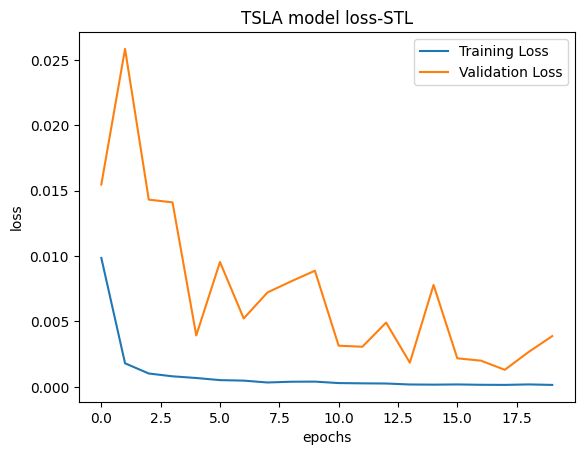

In [39]:
#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

##### Save model

In [ ]:
# Save the entire model as a `.keras` zip archive.
best_model.save(f'TSLA_model_hyperparameter_{filter}.keras')

# Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

In [42]:
best_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 40, 50)            2600      
                                                                 
 dropout_4 (Dropout)         (None, 40, 50)            0         
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 50)                5050      
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 7701 (30.08 KB)
Trainable params: 7701 (30.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


##### Load model

In [ ]:
new_model = tf.keras.models.load_model('TSLA_model_hyperparameter.keras')

##### Plot 

****************************TEST************************************


<Figure size 1000x600 with 0 Axes>

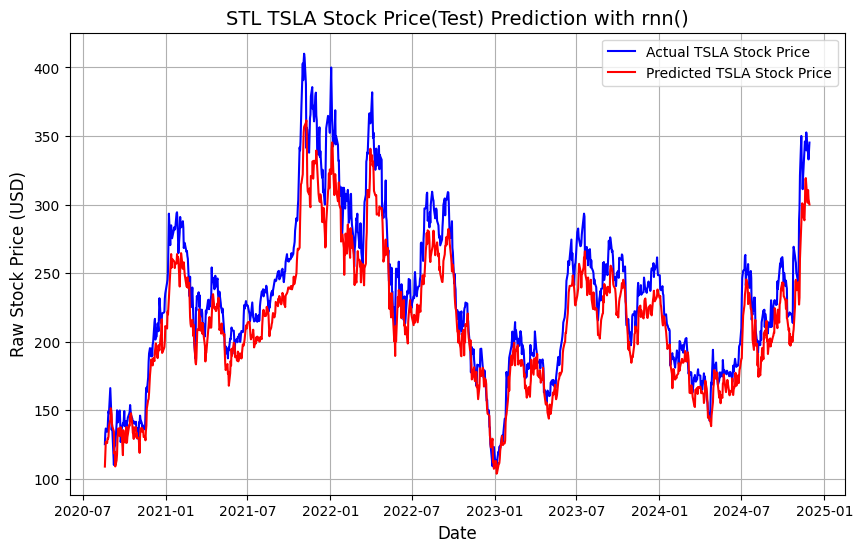

In [43]:
if attn:
    a = "attention"
else:
    a = ""

print("****************************TEST************************************")
model_name="rnn"
plot_simple(tesla_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,y_raw, predicted_stock_price_raw,10,6)
plot_interative(tesla_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,y_raw, predicted_stock_price_raw)

In [ ]:
rt_fft = tf.signal.fft(tesla_data['Close'])
fft = tf.signal.rfft(tesla_data[['Close']])
np.fft.fft(tesla_data['Close'])
recovered = tf.signal.ifft(rt_fft)
#plot tesla_data['Close] and recovered with x axis as tesla_data.index
plt.figure(figsize=(16,8))
plt.plot(tesla_data.index,tesla_data['Close'], label='Org Price', color='blue')
plt.plot(tesla_data.index,recovered, label='Rec Price', color='green')
plt.title('Tesla Stock Price')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()


In [72]:
len(tesla_data['Close'])

5534

In [ ]:
# import scipy.fft as fft
# # Generate a time-domain signal
# t = np.linspace(0, 1, 1000)
# x = np.sin(2 * np.pi * 10 * t) + np.sin(2 * np.pi * 20 * t)

# # Calculate the Fourier Transform
# X = fft.fft(tesla_data['Close'].values)
# freqs = fft.fftfreq(tesla_data['Close'].size,d=1)  # Calculate the frequencies

# from scipy import signal
# sos = signal.butter(2, 0.001, 'low', analog=False,output='sos')
# filtered = signal.sosfilt(sos, tesla_data[['Close']])
# # w, h = signal.freqs(b, a)

# # Plot the frequency-domain representation of the signal
# import matplotlib.pyplot as plt
# plt.plot(freqs, np.abs(X))
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Amplitude')
# plt.xlim([0, 50])  # Display frequencies from 0 to 50 Hz for clarity
# plt.show()

# #Plot the filtered data
# plt.figure(figsize=(10,6))
# plt.plot(tesla_data.index,filtered,label="filtered")
# plt.plot(tesla_data.index,tesla_data[['Close']],label="Actual")
# plt.title('Filtered Data')
# plt.xlabel('Time')
# plt.ylabel('Amplitude')
# plt.legend()
# plt.show()


#### AMD - Proposed Filter(hybrid) - fourier_wavelet

In [29]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=2
ticker="AMD" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="hybrid" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="hybrid"
tuning=False
stock_file_name="AMD_autoencoder_data.csv"
detail_index=8
#'haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dmey', 'gaus',
# 'mexh', 'morl', 'cgau', 'shan', 'fbsp', 'cmor'
wavelet_name="dmey"
approx_enable=False
threshold_enable=False
thresh_value=0
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning,detail_index,wavelet_name,approx_enable,threshold_enable,thresh_value)

In [30]:
win_size= 10#study_cnn.best_trial.params['win_size']
epoch_no= 100#study_cnn.best_trial.params['epoch_no']
drop_out= 0.4#round(study_cnn.best_trial.params['drop_out'],2)
units= 30#study_cnn.best_trial.params['units']
split_size= 0.4#round(study_cnn.best_trial.params['split_size'],2)
optimizer_options ='nadam'#study_cnn.best_trial.params['optimizer_name']
num_of_layers= 2#study_cnn.best_trial.params['no_layers']  
loss_option= 'mean_squared_error'#study_cnn.best_trial.params['loss_fn_name']
actv_option= 'gelu'#study_cnn.best_trial.params['activation_name']

# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))

unscaled X_train size (4194, 10)
scaled X_train size (4194, 10, 1) (4194,)


2025-01-08 12:26:39.406812: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13816 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:65:00.0, compute capability: 8.6
2025-01-08 12:26:39.601886: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-01-08 12:26:39.605082: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:225] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2025-01-08 12:26:39.605095: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:228] Used ptxas at ptxas
2025-01-08 12:26:39.605127: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to comp

(10, 1)
Epoch 1/100


2025-01-08 12:26:42.576228: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-01-08 12:26:42.578288: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-01-08 12:26:42.751822: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-01-08 12:26:42.753572: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or inval

  5/132 [>.............................] - ETA: 3s - loss: 1.7758 

2025-01-08 12:26:44.296685: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-01-08 12:26:44.365896: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



132/132 [==============================] - 9s 32ms/step - loss: 0.6841 - val_loss: 0.2030
Epoch 2/100
132/132 [==============================] - 4s 30ms/step - loss: 0.2757 - val_loss: 0.1611
Epoch 3/100
132/132 [==============================] - 4s 30ms/step - loss: 0.1540 - val_loss: 0.1465
Epoch 4/100
132/132 [==============================] - 4s 29ms/step - loss: 0.0830 - val_loss: 0.0637
Epoch 5/100
132/132 [==============================] - 4s 28ms/step - loss: 0.0541 - val_loss: 0.0421
Epoch 6/100
132/132 [==============================] - 4s 29ms/step - loss: 0.0359 - val_loss: 0.0285
Epoch 7/100
132/132 [==============================] - 4s 31ms/step - loss: 0.0261 - val_loss: 0.0199
Epoch 8/100
132/132 [==============================] - 4s 30ms/step - loss: 0.0202 - val_loss: 0.0156
Epoch 9/100
132/132 [==============================] - 4s 30ms/step - loss: 0.0165 - val_loss: 0.0070
Epoch 10/100
132/132 [==============================] - 4s 31ms/step - loss: 0.0139 - val_loss

In [ ]:
win_size= 10#study_cnn.best_trial.params['win_size']
epoch_no= 100#study_cnn.best_trial.params['epoch_no']
drop_out= 0.4#round(study_cnn.best_trial.params['drop_out'],2)
units= 30#study_cnn.best_trial.params['units']
split_size= 0.4#round(study_cnn.best_trial.params['split_size'],2)
optimizer_options ='adam'#study_cnn.best_trial.params['optimizer_name']
num_of_layers= 2#study_cnn.best_trial.params['no_layers']  
loss_option= 'mean_squared_error'#study_cnn.best_trial.params['loss_fn_name']
actv_option= 'gelu'#study_cnn.best_trial.params['activation_name']

# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))

In [31]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

44/44 [==============================] - 1s 6ms/step
**********************hybrid filter***************************
Mean Absolute Percentage Error (MAPE): 1.16%
Mean Absolute Error (MAE): 17.45
Root Mean Squared Error (RMSE): 43.21
R2 Score: -0.19


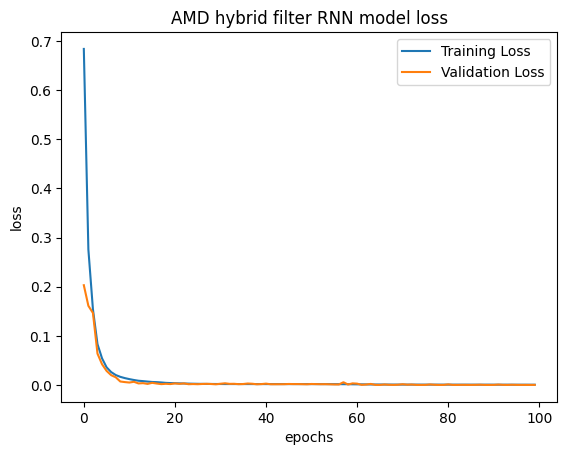

In [32]:

#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} hybrid filter RNN model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

In [33]:
# Save the entire model as a `.keras` zip archive.
best_model.save(f'saved_model_RNN/{ticker}_model_{study_naam}')

# Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

INFO:tensorflow:Assets written to: saved_model_RNN/AMD_model_hybrid/assets


INFO:tensorflow:Assets written to: saved_model_RNN/AMD_model_hybrid/assets


In [64]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['org_akam']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="RNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************
